# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01   26% |████████▌                       | 3.9MB 28.0MB/s eta 0:00:01    46% |██████████████▊                 | 6.7MB 44.3MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

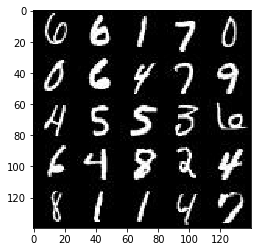

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

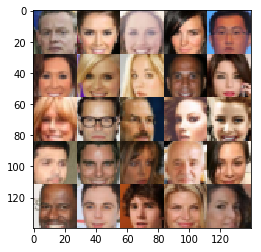

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learningRate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.7
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x(num_channels)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.layers.dropout(relu1, 1-keep_prob)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(relu2, 1-keep_prob)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(relu3, 1-keep_prob)
        # 4x4x256
        
        # flatten it
        flat = tf.contrib.layers.flatten(drop3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.7
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer 
        x1 = tf.layers.dense(z, 4*4*512, use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, 1-keep_prob, training=is_train)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1,padding='valid', use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, 1-keep_prob, training=is_train)
        # 7x7x256 now
        # ouptut = input*stride + max((kernel-stride),0) when valid
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, 1-keep_prob, training=is_train)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same', use_bias=False)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, 1-keep_prob, training=is_train)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(output_dim) now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} Step {}......".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                
                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, data_shape[3], data_image_mode)
                
                
        saver.save(sess, './checkpoints/generator.ckpt')        
                
                
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10...... Discriminator Loss: 1.9152... Generator Loss: 0.2669
Epoch 1/2 Step 20...... Discriminator Loss: 1.5498... Generator Loss: 0.4533
Epoch 1/2 Step 30...... Discriminator Loss: 2.4335... Generator Loss: 0.2004
Epoch 1/2 Step 40...... Discriminator Loss: 0.6179... Generator Loss: 2.1981
Epoch 1/2 Step 50...... Discriminator Loss: 0.6544... Generator Loss: 5.6221
Epoch 1/2 Step 60...... Discriminator Loss: 0.7806... Generator Loss: 3.3047
Epoch 1/2 Step 70...... Discriminator Loss: 0.4521... Generator Loss: 2.7659
Epoch 1/2 Step 80...... Discriminator Loss: 0.4952... Generator Loss: 2.2674
Epoch 1/2 Step 90...... Discriminator Loss: 1.3136... Generator Loss: 1.4612
Epoch 1/2 Step 100...... Discriminator Loss: 0.8229... Generator Loss: 2.5881


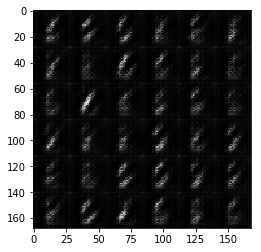

Epoch 1/2 Step 110...... Discriminator Loss: 0.6145... Generator Loss: 1.8846
Epoch 1/2 Step 120...... Discriminator Loss: 0.8006... Generator Loss: 2.2319
Epoch 1/2 Step 130...... Discriminator Loss: 1.1824... Generator Loss: 2.7846
Epoch 1/2 Step 140...... Discriminator Loss: 0.8552... Generator Loss: 1.3899
Epoch 1/2 Step 150...... Discriminator Loss: 1.1340... Generator Loss: 1.2948
Epoch 1/2 Step 160...... Discriminator Loss: 0.7345... Generator Loss: 1.6561
Epoch 1/2 Step 170...... Discriminator Loss: 0.8476... Generator Loss: 1.2381
Epoch 1/2 Step 180...... Discriminator Loss: 1.0643... Generator Loss: 2.2086
Epoch 1/2 Step 190...... Discriminator Loss: 1.1151... Generator Loss: 0.7026
Epoch 1/2 Step 200...... Discriminator Loss: 0.8881... Generator Loss: 1.1465


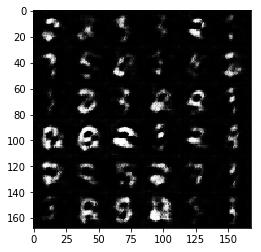

Epoch 1/2 Step 210...... Discriminator Loss: 1.0447... Generator Loss: 2.5340
Epoch 1/2 Step 220...... Discriminator Loss: 1.1232... Generator Loss: 0.7853
Epoch 1/2 Step 230...... Discriminator Loss: 1.0321... Generator Loss: 1.2900
Epoch 1/2 Step 240...... Discriminator Loss: 0.9667... Generator Loss: 1.0243
Epoch 1/2 Step 250...... Discriminator Loss: 1.0379... Generator Loss: 2.0160
Epoch 1/2 Step 260...... Discriminator Loss: 0.8468... Generator Loss: 1.5013
Epoch 1/2 Step 270...... Discriminator Loss: 1.0332... Generator Loss: 2.1041
Epoch 1/2 Step 280...... Discriminator Loss: 0.8797... Generator Loss: 1.8792
Epoch 1/2 Step 290...... Discriminator Loss: 1.1497... Generator Loss: 0.8152
Epoch 1/2 Step 300...... Discriminator Loss: 1.2879... Generator Loss: 2.5617


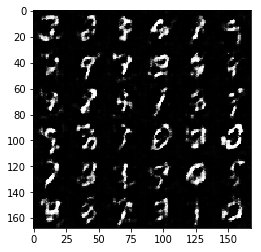

Epoch 1/2 Step 310...... Discriminator Loss: 0.9504... Generator Loss: 1.2908
Epoch 1/2 Step 320...... Discriminator Loss: 0.9360... Generator Loss: 1.5074
Epoch 1/2 Step 330...... Discriminator Loss: 1.2031... Generator Loss: 0.7226
Epoch 1/2 Step 340...... Discriminator Loss: 1.0583... Generator Loss: 0.9650
Epoch 1/2 Step 350...... Discriminator Loss: 0.9787... Generator Loss: 1.0799
Epoch 1/2 Step 360...... Discriminator Loss: 0.9819... Generator Loss: 1.5257
Epoch 1/2 Step 370...... Discriminator Loss: 0.8804... Generator Loss: 1.5794
Epoch 1/2 Step 380...... Discriminator Loss: 1.1463... Generator Loss: 0.7611
Epoch 1/2 Step 390...... Discriminator Loss: 0.9672... Generator Loss: 1.6063
Epoch 1/2 Step 400...... Discriminator Loss: 0.9729... Generator Loss: 1.5587


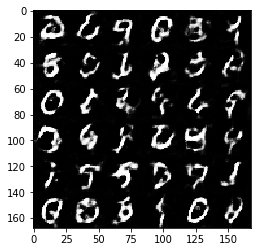

Epoch 1/2 Step 410...... Discriminator Loss: 0.8964... Generator Loss: 1.2973
Epoch 1/2 Step 420...... Discriminator Loss: 1.2312... Generator Loss: 2.0365
Epoch 1/2 Step 430...... Discriminator Loss: 1.0016... Generator Loss: 0.9767
Epoch 1/2 Step 440...... Discriminator Loss: 0.8643... Generator Loss: 1.2057
Epoch 1/2 Step 450...... Discriminator Loss: 1.0418... Generator Loss: 1.0072
Epoch 1/2 Step 460...... Discriminator Loss: 0.8253... Generator Loss: 1.3780
Epoch 1/2 Step 470...... Discriminator Loss: 1.0996... Generator Loss: 0.7749
Epoch 1/2 Step 480...... Discriminator Loss: 0.9050... Generator Loss: 1.1663
Epoch 1/2 Step 490...... Discriminator Loss: 1.1197... Generator Loss: 0.7504
Epoch 1/2 Step 500...... Discriminator Loss: 1.1797... Generator Loss: 0.8308


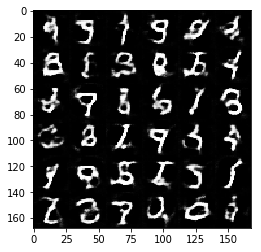

Epoch 1/2 Step 510...... Discriminator Loss: 1.0220... Generator Loss: 2.2633
Epoch 1/2 Step 520...... Discriminator Loss: 0.9814... Generator Loss: 1.6757
Epoch 1/2 Step 530...... Discriminator Loss: 0.9237... Generator Loss: 1.2012
Epoch 1/2 Step 540...... Discriminator Loss: 0.9531... Generator Loss: 1.7255
Epoch 1/2 Step 550...... Discriminator Loss: 0.8250... Generator Loss: 1.5635
Epoch 1/2 Step 560...... Discriminator Loss: 0.9058... Generator Loss: 1.4017
Epoch 1/2 Step 570...... Discriminator Loss: 0.9194... Generator Loss: 1.8698
Epoch 1/2 Step 580...... Discriminator Loss: 1.0222... Generator Loss: 0.9518
Epoch 1/2 Step 590...... Discriminator Loss: 1.0613... Generator Loss: 2.0579
Epoch 1/2 Step 600...... Discriminator Loss: 0.9418... Generator Loss: 1.3956


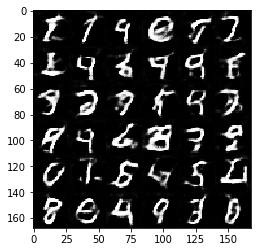

Epoch 1/2 Step 610...... Discriminator Loss: 0.8668... Generator Loss: 1.1723
Epoch 1/2 Step 620...... Discriminator Loss: 1.0472... Generator Loss: 0.8568
Epoch 1/2 Step 630...... Discriminator Loss: 1.0184... Generator Loss: 0.9738
Epoch 1/2 Step 640...... Discriminator Loss: 0.9436... Generator Loss: 1.0556
Epoch 1/2 Step 650...... Discriminator Loss: 0.8910... Generator Loss: 1.2794
Epoch 1/2 Step 660...... Discriminator Loss: 0.9074... Generator Loss: 0.9862
Epoch 1/2 Step 670...... Discriminator Loss: 0.8492... Generator Loss: 1.5957
Epoch 1/2 Step 680...... Discriminator Loss: 1.1730... Generator Loss: 0.6488
Epoch 1/2 Step 690...... Discriminator Loss: 1.1284... Generator Loss: 0.7330
Epoch 1/2 Step 700...... Discriminator Loss: 1.0586... Generator Loss: 0.7767


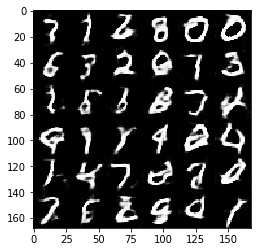

Epoch 1/2 Step 710...... Discriminator Loss: 0.8602... Generator Loss: 1.5923
Epoch 1/2 Step 720...... Discriminator Loss: 1.0642... Generator Loss: 2.4356
Epoch 1/2 Step 730...... Discriminator Loss: 0.9044... Generator Loss: 1.5418
Epoch 1/2 Step 740...... Discriminator Loss: 0.7222... Generator Loss: 1.5065
Epoch 1/2 Step 750...... Discriminator Loss: 0.9124... Generator Loss: 1.0454
Epoch 1/2 Step 760...... Discriminator Loss: 1.0486... Generator Loss: 2.5767
Epoch 1/2 Step 770...... Discriminator Loss: 1.0171... Generator Loss: 0.9497
Epoch 1/2 Step 780...... Discriminator Loss: 0.8243... Generator Loss: 1.4085
Epoch 1/2 Step 790...... Discriminator Loss: 0.8505... Generator Loss: 1.6998
Epoch 1/2 Step 800...... Discriminator Loss: 0.8152... Generator Loss: 1.6679


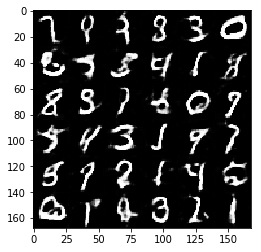

Epoch 1/2 Step 810...... Discriminator Loss: 0.9632... Generator Loss: 0.9521
Epoch 1/2 Step 820...... Discriminator Loss: 0.7909... Generator Loss: 1.0955
Epoch 1/2 Step 830...... Discriminator Loss: 0.8330... Generator Loss: 1.1760
Epoch 1/2 Step 840...... Discriminator Loss: 1.0328... Generator Loss: 0.7247
Epoch 1/2 Step 850...... Discriminator Loss: 0.9297... Generator Loss: 1.0745
Epoch 1/2 Step 860...... Discriminator Loss: 0.8176... Generator Loss: 1.3613
Epoch 1/2 Step 870...... Discriminator Loss: 0.8055... Generator Loss: 1.3034
Epoch 1/2 Step 880...... Discriminator Loss: 0.7380... Generator Loss: 1.4818
Epoch 1/2 Step 890...... Discriminator Loss: 1.1893... Generator Loss: 0.7378
Epoch 1/2 Step 900...... Discriminator Loss: 0.9777... Generator Loss: 1.1362


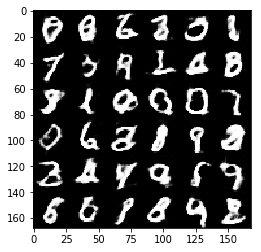

Epoch 1/2 Step 910...... Discriminator Loss: 0.8788... Generator Loss: 1.2111
Epoch 1/2 Step 920...... Discriminator Loss: 0.7823... Generator Loss: 1.4704
Epoch 1/2 Step 930...... Discriminator Loss: 0.7724... Generator Loss: 1.5066
Epoch 2/2 Step 940...... Discriminator Loss: 0.6699... Generator Loss: 1.3909
Epoch 2/2 Step 950...... Discriminator Loss: 0.7790... Generator Loss: 1.1545
Epoch 2/2 Step 960...... Discriminator Loss: 1.5710... Generator Loss: 0.3766
Epoch 2/2 Step 970...... Discriminator Loss: 0.9288... Generator Loss: 1.1856
Epoch 2/2 Step 980...... Discriminator Loss: 0.7081... Generator Loss: 1.7648
Epoch 2/2 Step 990...... Discriminator Loss: 0.7155... Generator Loss: 1.2952
Epoch 2/2 Step 1000...... Discriminator Loss: 0.6889... Generator Loss: 1.8140


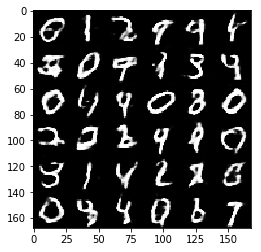

Epoch 2/2 Step 1010...... Discriminator Loss: 0.7874... Generator Loss: 1.2433
Epoch 2/2 Step 1020...... Discriminator Loss: 0.6983... Generator Loss: 1.2770
Epoch 2/2 Step 1030...... Discriminator Loss: 0.6826... Generator Loss: 1.7237
Epoch 2/2 Step 1040...... Discriminator Loss: 1.1222... Generator Loss: 0.9941
Epoch 2/2 Step 1050...... Discriminator Loss: 0.9643... Generator Loss: 2.0724
Epoch 2/2 Step 1060...... Discriminator Loss: 0.7555... Generator Loss: 1.1626
Epoch 2/2 Step 1070...... Discriminator Loss: 0.8733... Generator Loss: 1.1953
Epoch 2/2 Step 1080...... Discriminator Loss: 0.7106... Generator Loss: 1.9052
Epoch 2/2 Step 1090...... Discriminator Loss: 0.8844... Generator Loss: 1.1045
Epoch 2/2 Step 1100...... Discriminator Loss: 0.7511... Generator Loss: 1.2486


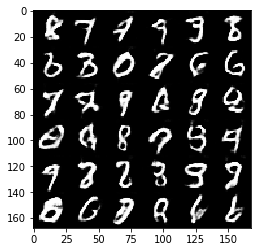

Epoch 2/2 Step 1110...... Discriminator Loss: 1.1495... Generator Loss: 3.2650
Epoch 2/2 Step 1120...... Discriminator Loss: 0.8468... Generator Loss: 1.2152
Epoch 2/2 Step 1130...... Discriminator Loss: 0.6337... Generator Loss: 1.6490
Epoch 2/2 Step 1140...... Discriminator Loss: 0.7878... Generator Loss: 1.2584
Epoch 2/2 Step 1150...... Discriminator Loss: 0.7968... Generator Loss: 1.2550
Epoch 2/2 Step 1160...... Discriminator Loss: 0.6736... Generator Loss: 1.5278
Epoch 2/2 Step 1170...... Discriminator Loss: 0.6689... Generator Loss: 2.4927
Epoch 2/2 Step 1180...... Discriminator Loss: 0.9372... Generator Loss: 1.0516
Epoch 2/2 Step 1190...... Discriminator Loss: 0.7418... Generator Loss: 1.7235
Epoch 2/2 Step 1200...... Discriminator Loss: 0.7643... Generator Loss: 1.2090


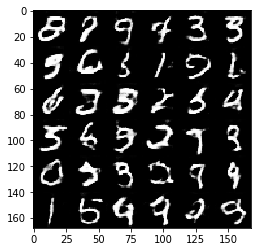

Epoch 2/2 Step 1210...... Discriminator Loss: 0.7156... Generator Loss: 1.6663
Epoch 2/2 Step 1220...... Discriminator Loss: 0.7611... Generator Loss: 2.3654
Epoch 2/2 Step 1230...... Discriminator Loss: 1.8235... Generator Loss: 3.7228
Epoch 2/2 Step 1240...... Discriminator Loss: 0.9763... Generator Loss: 1.0374
Epoch 2/2 Step 1250...... Discriminator Loss: 0.7410... Generator Loss: 1.4047
Epoch 2/2 Step 1260...... Discriminator Loss: 0.9039... Generator Loss: 0.9948
Epoch 2/2 Step 1270...... Discriminator Loss: 0.8636... Generator Loss: 0.9584
Epoch 2/2 Step 1280...... Discriminator Loss: 0.7480... Generator Loss: 2.2282
Epoch 2/2 Step 1290...... Discriminator Loss: 0.8794... Generator Loss: 2.0193
Epoch 2/2 Step 1300...... Discriminator Loss: 0.8171... Generator Loss: 1.8569


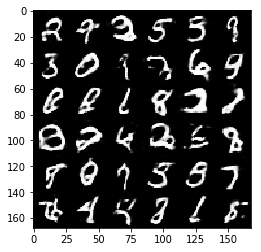

Epoch 2/2 Step 1310...... Discriminator Loss: 0.8414... Generator Loss: 1.1261
Epoch 2/2 Step 1320...... Discriminator Loss: 0.7234... Generator Loss: 1.4057
Epoch 2/2 Step 1330...... Discriminator Loss: 0.8057... Generator Loss: 2.6845
Epoch 2/2 Step 1340...... Discriminator Loss: 0.8346... Generator Loss: 2.5436
Epoch 2/2 Step 1350...... Discriminator Loss: 0.5717... Generator Loss: 1.7533
Epoch 2/2 Step 1360...... Discriminator Loss: 0.6666... Generator Loss: 1.6523
Epoch 2/2 Step 1370...... Discriminator Loss: 0.5963... Generator Loss: 1.8195
Epoch 2/2 Step 1380...... Discriminator Loss: 0.5289... Generator Loss: 1.8341
Epoch 2/2 Step 1390...... Discriminator Loss: 0.6488... Generator Loss: 3.0136
Epoch 2/2 Step 1400...... Discriminator Loss: 1.4821... Generator Loss: 0.7714


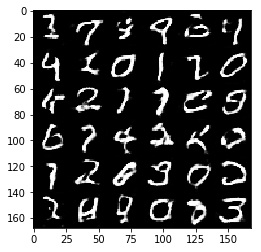

Epoch 2/2 Step 1410...... Discriminator Loss: 0.6012... Generator Loss: 1.8549
Epoch 2/2 Step 1420...... Discriminator Loss: 0.7814... Generator Loss: 1.1868
Epoch 2/2 Step 1430...... Discriminator Loss: 0.5756... Generator Loss: 2.8010
Epoch 2/2 Step 1440...... Discriminator Loss: 0.5873... Generator Loss: 1.8525
Epoch 2/2 Step 1450...... Discriminator Loss: 0.6120... Generator Loss: 1.7705
Epoch 2/2 Step 1460...... Discriminator Loss: 0.8603... Generator Loss: 2.6485
Epoch 2/2 Step 1470...... Discriminator Loss: 1.0868... Generator Loss: 2.6058
Epoch 2/2 Step 1480...... Discriminator Loss: 0.7522... Generator Loss: 2.3380
Epoch 2/2 Step 1490...... Discriminator Loss: 0.5539... Generator Loss: 2.0456
Epoch 2/2 Step 1500...... Discriminator Loss: 1.1491... Generator Loss: 0.7228


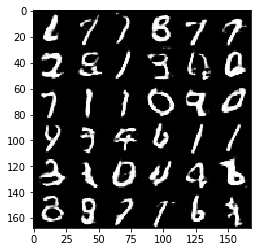

Epoch 2/2 Step 1510...... Discriminator Loss: 0.7124... Generator Loss: 1.6409
Epoch 2/2 Step 1520...... Discriminator Loss: 0.5845... Generator Loss: 1.6345
Epoch 2/2 Step 1530...... Discriminator Loss: 1.4191... Generator Loss: 3.3290
Epoch 2/2 Step 1540...... Discriminator Loss: 0.7509... Generator Loss: 1.4010
Epoch 2/2 Step 1550...... Discriminator Loss: 0.6157... Generator Loss: 1.6995
Epoch 2/2 Step 1560...... Discriminator Loss: 0.5835... Generator Loss: 1.6411
Epoch 2/2 Step 1570...... Discriminator Loss: 0.6499... Generator Loss: 1.3940
Epoch 2/2 Step 1580...... Discriminator Loss: 0.4890... Generator Loss: 2.3107
Epoch 2/2 Step 1590...... Discriminator Loss: 0.6981... Generator Loss: 1.4732
Epoch 2/2 Step 1600...... Discriminator Loss: 0.8717... Generator Loss: 1.9695


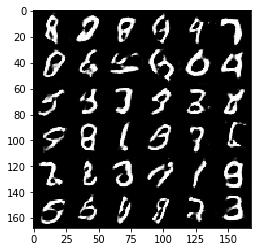

Epoch 2/2 Step 1610...... Discriminator Loss: 0.6210... Generator Loss: 1.8692
Epoch 2/2 Step 1620...... Discriminator Loss: 0.8504... Generator Loss: 1.1268
Epoch 2/2 Step 1630...... Discriminator Loss: 0.5322... Generator Loss: 2.0644
Epoch 2/2 Step 1640...... Discriminator Loss: 0.6313... Generator Loss: 2.1465
Epoch 2/2 Step 1650...... Discriminator Loss: 0.5868... Generator Loss: 1.8022
Epoch 2/2 Step 1660...... Discriminator Loss: 0.5718... Generator Loss: 2.0315
Epoch 2/2 Step 1670...... Discriminator Loss: 0.7212... Generator Loss: 1.2364
Epoch 2/2 Step 1680...... Discriminator Loss: 0.5917... Generator Loss: 2.0906
Epoch 2/2 Step 1690...... Discriminator Loss: 0.4697... Generator Loss: 2.6116
Epoch 2/2 Step 1700...... Discriminator Loss: 0.4954... Generator Loss: 2.2414


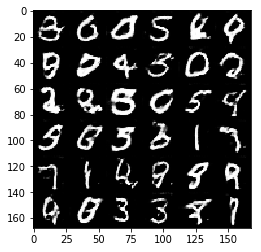

Epoch 2/2 Step 1710...... Discriminator Loss: 0.7048... Generator Loss: 1.6576
Epoch 2/2 Step 1720...... Discriminator Loss: 0.8516... Generator Loss: 1.1344
Epoch 2/2 Step 1730...... Discriminator Loss: 0.6872... Generator Loss: 1.8822
Epoch 2/2 Step 1740...... Discriminator Loss: 0.7371... Generator Loss: 3.6136
Epoch 2/2 Step 1750...... Discriminator Loss: 0.6389... Generator Loss: 1.6441
Epoch 2/2 Step 1760...... Discriminator Loss: 0.8015... Generator Loss: 1.1251
Epoch 2/2 Step 1770...... Discriminator Loss: 0.6703... Generator Loss: 1.5608
Epoch 2/2 Step 1780...... Discriminator Loss: 0.5647... Generator Loss: 1.8733
Epoch 2/2 Step 1790...... Discriminator Loss: 0.5159... Generator Loss: 1.9823
Epoch 2/2 Step 1800...... Discriminator Loss: 0.4987... Generator Loss: 2.4247


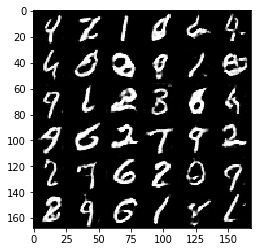

Epoch 2/2 Step 1810...... Discriminator Loss: 0.5165... Generator Loss: 2.2213
Epoch 2/2 Step 1820...... Discriminator Loss: 0.4943... Generator Loss: 2.5099
Epoch 2/2 Step 1830...... Discriminator Loss: 0.6628... Generator Loss: 3.0393
Epoch 2/2 Step 1840...... Discriminator Loss: 0.5704... Generator Loss: 2.6699
Epoch 2/2 Step 1850...... Discriminator Loss: 0.6260... Generator Loss: 1.6712
Epoch 2/2 Step 1860...... Discriminator Loss: 0.5273... Generator Loss: 2.4167
Epoch 2/2 Step 1870...... Discriminator Loss: 0.5869... Generator Loss: 1.8798


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 Step 10...... Discriminator Loss: 1.2523... Generator Loss: 0.8468
Epoch 1/2 Step 20...... Discriminator Loss: 0.5825... Generator Loss: 2.9996
Epoch 1/2 Step 30...... Discriminator Loss: 1.2016... Generator Loss: 0.8004
Epoch 1/2 Step 40...... Discriminator Loss: 2.3441... Generator Loss: 11.5070
Epoch 1/2 Step 50...... Discriminator Loss: 0.9674... Generator Loss: 5.2569
Epoch 1/2 Step 60...... Discriminator Loss: 0.4740... Generator Loss: 3.0377
Epoch 1/2 Step 70...... Discriminator Loss: 0.6165... Generator Loss: 2.0253
Epoch 1/2 Step 80...... Discriminator Loss: 0.6102... Generator Loss: 1.8999
Epoch 1/2 Step 90...... Discriminator Loss: 0.4647... Generator Loss: 2.9717
Epoch 1/2 Step 100...... Discriminator Loss: 0.4361... Generator Loss: 3.1416


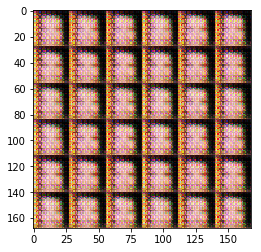

Epoch 1/2 Step 110...... Discriminator Loss: 0.3865... Generator Loss: 4.2868
Epoch 1/2 Step 120...... Discriminator Loss: 0.3951... Generator Loss: 3.5583
Epoch 1/2 Step 130...... Discriminator Loss: 0.3959... Generator Loss: 3.2187
Epoch 1/2 Step 140...... Discriminator Loss: 0.4733... Generator Loss: 2.4625
Epoch 1/2 Step 150...... Discriminator Loss: 0.4634... Generator Loss: 2.5204
Epoch 1/2 Step 160...... Discriminator Loss: 0.4063... Generator Loss: 3.4067
Epoch 1/2 Step 170...... Discriminator Loss: 0.5054... Generator Loss: 2.4439
Epoch 1/2 Step 180...... Discriminator Loss: 0.4149... Generator Loss: 3.3394
Epoch 1/2 Step 190...... Discriminator Loss: 0.4027... Generator Loss: 3.1734
Epoch 1/2 Step 200...... Discriminator Loss: 0.3980... Generator Loss: 3.0769


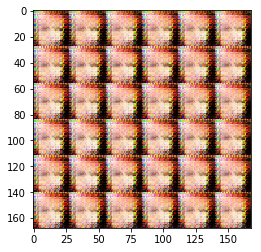

Epoch 1/2 Step 210...... Discriminator Loss: 0.3740... Generator Loss: 5.1255
Epoch 1/2 Step 220...... Discriminator Loss: 0.4065... Generator Loss: 4.1017
Epoch 1/2 Step 230...... Discriminator Loss: 0.6665... Generator Loss: 1.9139
Epoch 1/2 Step 240...... Discriminator Loss: 1.0838... Generator Loss: 0.9674
Epoch 1/2 Step 250...... Discriminator Loss: 0.7872... Generator Loss: 2.8147
Epoch 1/2 Step 260...... Discriminator Loss: 0.7390... Generator Loss: 1.6513
Epoch 1/2 Step 270...... Discriminator Loss: 0.7610... Generator Loss: 1.5282
Epoch 1/2 Step 280...... Discriminator Loss: 0.5277... Generator Loss: 2.4942
Epoch 1/2 Step 290...... Discriminator Loss: 0.8891... Generator Loss: 1.5121
Epoch 1/2 Step 300...... Discriminator Loss: 1.0467... Generator Loss: 5.1361


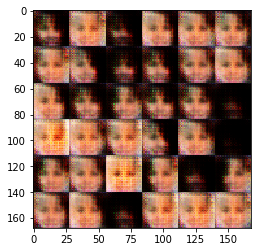

Epoch 1/2 Step 310...... Discriminator Loss: 0.8857... Generator Loss: 1.2529
Epoch 1/2 Step 320...... Discriminator Loss: 0.5771... Generator Loss: 2.2236
Epoch 1/2 Step 330...... Discriminator Loss: 1.6217... Generator Loss: 0.4741
Epoch 1/2 Step 340...... Discriminator Loss: 0.5836... Generator Loss: 3.3150
Epoch 1/2 Step 350...... Discriminator Loss: 0.4372... Generator Loss: 3.8657
Epoch 1/2 Step 360...... Discriminator Loss: 0.7859... Generator Loss: 3.6996
Epoch 1/2 Step 370...... Discriminator Loss: 0.6604... Generator Loss: 4.2378
Epoch 1/2 Step 380...... Discriminator Loss: 0.4565... Generator Loss: 2.5574
Epoch 1/2 Step 390...... Discriminator Loss: 1.0675... Generator Loss: 1.0955
Epoch 1/2 Step 400...... Discriminator Loss: 0.5636... Generator Loss: 2.1911


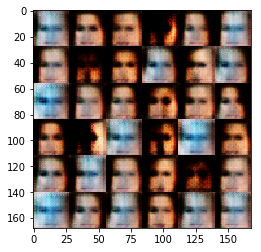

Epoch 1/2 Step 410...... Discriminator Loss: 0.8210... Generator Loss: 2.9944
Epoch 1/2 Step 420...... Discriminator Loss: 0.6738... Generator Loss: 1.4881
Epoch 1/2 Step 430...... Discriminator Loss: 0.7143... Generator Loss: 1.5523
Epoch 1/2 Step 440...... Discriminator Loss: 0.7316... Generator Loss: 2.9725
Epoch 1/2 Step 450...... Discriminator Loss: 0.8532... Generator Loss: 2.9933
Epoch 1/2 Step 460...... Discriminator Loss: 0.9212... Generator Loss: 1.0873
Epoch 1/2 Step 470...... Discriminator Loss: 0.6112... Generator Loss: 2.1377
Epoch 1/2 Step 480...... Discriminator Loss: 0.8527... Generator Loss: 1.3180
Epoch 1/2 Step 490...... Discriminator Loss: 0.6798... Generator Loss: 1.5511
Epoch 1/2 Step 500...... Discriminator Loss: 0.5249... Generator Loss: 2.3863


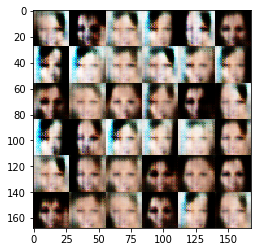

Epoch 1/2 Step 510...... Discriminator Loss: 1.1522... Generator Loss: 5.5689
Epoch 1/2 Step 520...... Discriminator Loss: 0.5943... Generator Loss: 1.6910
Epoch 1/2 Step 530...... Discriminator Loss: 1.0821... Generator Loss: 1.0376
Epoch 1/2 Step 540...... Discriminator Loss: 0.6779... Generator Loss: 1.6825
Epoch 1/2 Step 550...... Discriminator Loss: 0.7637... Generator Loss: 1.3794
Epoch 1/2 Step 560...... Discriminator Loss: 0.7726... Generator Loss: 2.7416
Epoch 1/2 Step 570...... Discriminator Loss: 1.6546... Generator Loss: 4.5034
Epoch 1/2 Step 580...... Discriminator Loss: 0.8133... Generator Loss: 1.4775
Epoch 1/2 Step 590...... Discriminator Loss: 0.8472... Generator Loss: 1.2664
Epoch 1/2 Step 600...... Discriminator Loss: 0.9549... Generator Loss: 0.9362


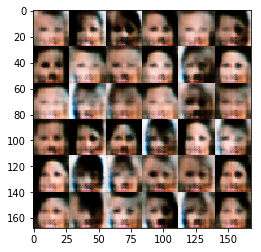

Epoch 1/2 Step 610...... Discriminator Loss: 0.9533... Generator Loss: 4.2162
Epoch 1/2 Step 620...... Discriminator Loss: 1.5314... Generator Loss: 0.5561
Epoch 1/2 Step 630...... Discriminator Loss: 0.9960... Generator Loss: 1.1016
Epoch 1/2 Step 640...... Discriminator Loss: 0.7860... Generator Loss: 1.6626
Epoch 1/2 Step 650...... Discriminator Loss: 0.6549... Generator Loss: 2.0234
Epoch 1/2 Step 660...... Discriminator Loss: 0.6658... Generator Loss: 1.7523
Epoch 1/2 Step 670...... Discriminator Loss: 0.7872... Generator Loss: 1.3466
Epoch 1/2 Step 680...... Discriminator Loss: 0.5286... Generator Loss: 2.6338
Epoch 1/2 Step 690...... Discriminator Loss: 0.9788... Generator Loss: 2.4455
Epoch 1/2 Step 700...... Discriminator Loss: 0.6531... Generator Loss: 2.1467


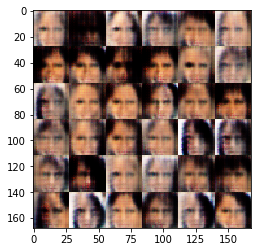

Epoch 1/2 Step 710...... Discriminator Loss: 0.6721... Generator Loss: 2.2037
Epoch 1/2 Step 720...... Discriminator Loss: 0.7119... Generator Loss: 1.7479
Epoch 1/2 Step 730...... Discriminator Loss: 0.8706... Generator Loss: 1.0572
Epoch 1/2 Step 740...... Discriminator Loss: 0.7178... Generator Loss: 1.8331
Epoch 1/2 Step 750...... Discriminator Loss: 0.9756... Generator Loss: 3.3886
Epoch 1/2 Step 760...... Discriminator Loss: 1.1799... Generator Loss: 0.8049
Epoch 1/2 Step 770...... Discriminator Loss: 0.9120... Generator Loss: 1.1817
Epoch 1/2 Step 780...... Discriminator Loss: 0.6814... Generator Loss: 1.9191
Epoch 1/2 Step 790...... Discriminator Loss: 0.8973... Generator Loss: 2.0076
Epoch 1/2 Step 800...... Discriminator Loss: 1.0371... Generator Loss: 2.5959


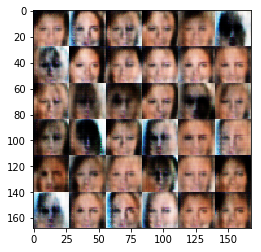

Epoch 1/2 Step 810...... Discriminator Loss: 0.8698... Generator Loss: 1.9286
Epoch 1/2 Step 820...... Discriminator Loss: 1.4255... Generator Loss: 3.2946
Epoch 1/2 Step 830...... Discriminator Loss: 0.8473... Generator Loss: 1.7689
Epoch 1/2 Step 840...... Discriminator Loss: 1.1012... Generator Loss: 0.8804
Epoch 1/2 Step 850...... Discriminator Loss: 0.7158... Generator Loss: 1.6960
Epoch 1/2 Step 860...... Discriminator Loss: 0.7860... Generator Loss: 1.8203
Epoch 1/2 Step 870...... Discriminator Loss: 1.0927... Generator Loss: 3.3437
Epoch 1/2 Step 880...... Discriminator Loss: 0.9071... Generator Loss: 2.0133
Epoch 1/2 Step 890...... Discriminator Loss: 0.7862... Generator Loss: 1.7130
Epoch 1/2 Step 900...... Discriminator Loss: 1.0015... Generator Loss: 1.0409


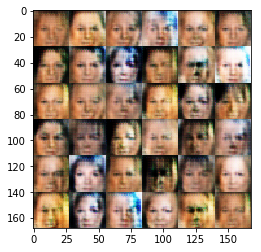

Epoch 1/2 Step 910...... Discriminator Loss: 0.7672... Generator Loss: 1.7634
Epoch 1/2 Step 920...... Discriminator Loss: 1.6744... Generator Loss: 4.2023
Epoch 1/2 Step 930...... Discriminator Loss: 0.8054... Generator Loss: 1.8133
Epoch 1/2 Step 940...... Discriminator Loss: 0.7970... Generator Loss: 2.0691
Epoch 1/2 Step 950...... Discriminator Loss: 1.5697... Generator Loss: 0.4214
Epoch 1/2 Step 960...... Discriminator Loss: 0.9653... Generator Loss: 1.2324
Epoch 1/2 Step 970...... Discriminator Loss: 1.0170... Generator Loss: 1.4498
Epoch 1/2 Step 980...... Discriminator Loss: 0.9288... Generator Loss: 2.0181
Epoch 1/2 Step 990...... Discriminator Loss: 1.3774... Generator Loss: 0.5915
Epoch 1/2 Step 1000...... Discriminator Loss: 0.9933... Generator Loss: 1.0070


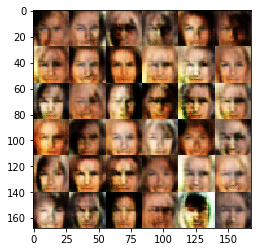

Epoch 1/2 Step 1010...... Discriminator Loss: 0.8550... Generator Loss: 1.3371
Epoch 1/2 Step 1020...... Discriminator Loss: 0.9387... Generator Loss: 1.3612
Epoch 1/2 Step 1030...... Discriminator Loss: 0.7735... Generator Loss: 1.6731
Epoch 1/2 Step 1040...... Discriminator Loss: 1.3141... Generator Loss: 0.6773
Epoch 1/2 Step 1050...... Discriminator Loss: 0.8355... Generator Loss: 2.3721
Epoch 1/2 Step 1060...... Discriminator Loss: 0.9813... Generator Loss: 1.8658
Epoch 1/2 Step 1070...... Discriminator Loss: 0.8517... Generator Loss: 1.7711
Epoch 1/2 Step 1080...... Discriminator Loss: 1.0557... Generator Loss: 1.3476
Epoch 1/2 Step 1090...... Discriminator Loss: 0.8930... Generator Loss: 1.6971
Epoch 1/2 Step 1100...... Discriminator Loss: 1.3009... Generator Loss: 0.5695


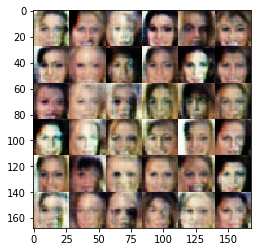

Epoch 1/2 Step 1110...... Discriminator Loss: 0.8179... Generator Loss: 1.3385
Epoch 1/2 Step 1120...... Discriminator Loss: 1.0920... Generator Loss: 0.7485
Epoch 1/2 Step 1130...... Discriminator Loss: 0.8565... Generator Loss: 2.3473
Epoch 1/2 Step 1140...... Discriminator Loss: 0.9168... Generator Loss: 1.4530
Epoch 1/2 Step 1150...... Discriminator Loss: 0.9357... Generator Loss: 1.2604
Epoch 1/2 Step 1160...... Discriminator Loss: 0.8567... Generator Loss: 1.9641
Epoch 1/2 Step 1170...... Discriminator Loss: 0.7941... Generator Loss: 2.3988
Epoch 1/2 Step 1180...... Discriminator Loss: 0.8145... Generator Loss: 1.3058
Epoch 1/2 Step 1190...... Discriminator Loss: 0.8679... Generator Loss: 2.5985
Epoch 1/2 Step 1200...... Discriminator Loss: 1.0524... Generator Loss: 0.9931


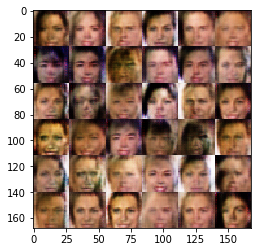

Epoch 1/2 Step 1210...... Discriminator Loss: 1.1938... Generator Loss: 0.7014
Epoch 1/2 Step 1220...... Discriminator Loss: 0.8588... Generator Loss: 1.6451
Epoch 1/2 Step 1230...... Discriminator Loss: 0.8159... Generator Loss: 2.2806
Epoch 1/2 Step 1240...... Discriminator Loss: 0.8429... Generator Loss: 1.8950
Epoch 1/2 Step 1250...... Discriminator Loss: 1.3191... Generator Loss: 0.6021
Epoch 1/2 Step 1260...... Discriminator Loss: 0.7968... Generator Loss: 1.9745
Epoch 1/2 Step 1270...... Discriminator Loss: 0.8941... Generator Loss: 1.2004
Epoch 1/2 Step 1280...... Discriminator Loss: 0.9439... Generator Loss: 1.5495
Epoch 1/2 Step 1290...... Discriminator Loss: 0.8569... Generator Loss: 1.5577
Epoch 1/2 Step 1300...... Discriminator Loss: 0.8304... Generator Loss: 1.1638


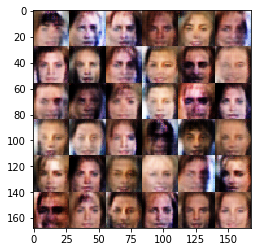

Epoch 1/2 Step 1310...... Discriminator Loss: 0.9229... Generator Loss: 2.6153
Epoch 1/2 Step 1320...... Discriminator Loss: 0.7511... Generator Loss: 1.8194
Epoch 1/2 Step 1330...... Discriminator Loss: 1.1980... Generator Loss: 2.0995
Epoch 1/2 Step 1340...... Discriminator Loss: 0.8487... Generator Loss: 1.5102
Epoch 1/2 Step 1350...... Discriminator Loss: 0.8982... Generator Loss: 1.4409
Epoch 1/2 Step 1360...... Discriminator Loss: 1.4215... Generator Loss: 0.5463
Epoch 1/2 Step 1370...... Discriminator Loss: 0.7900... Generator Loss: 1.7693
Epoch 1/2 Step 1380...... Discriminator Loss: 0.9556... Generator Loss: 2.0032
Epoch 1/2 Step 1390...... Discriminator Loss: 1.0378... Generator Loss: 1.9744
Epoch 1/2 Step 1400...... Discriminator Loss: 0.8712... Generator Loss: 1.8049


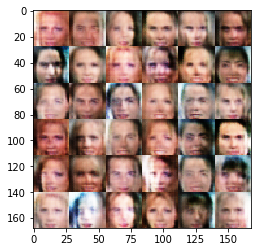

Epoch 1/2 Step 1410...... Discriminator Loss: 0.9212... Generator Loss: 1.3792
Epoch 1/2 Step 1420...... Discriminator Loss: 1.1016... Generator Loss: 0.9645
Epoch 1/2 Step 1430...... Discriminator Loss: 0.9888... Generator Loss: 0.8747
Epoch 1/2 Step 1440...... Discriminator Loss: 0.9003... Generator Loss: 1.1519
Epoch 1/2 Step 1450...... Discriminator Loss: 1.1036... Generator Loss: 0.8853
Epoch 1/2 Step 1460...... Discriminator Loss: 1.5678... Generator Loss: 0.4675
Epoch 1/2 Step 1470...... Discriminator Loss: 0.8565... Generator Loss: 1.3436
Epoch 1/2 Step 1480...... Discriminator Loss: 1.0105... Generator Loss: 1.7928
Epoch 1/2 Step 1490...... Discriminator Loss: 0.9718... Generator Loss: 1.1240
Epoch 1/2 Step 1500...... Discriminator Loss: 0.8665... Generator Loss: 1.3071


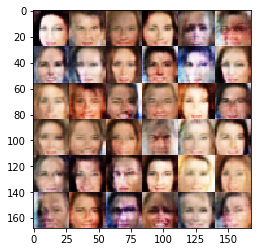

Epoch 1/2 Step 1510...... Discriminator Loss: 1.0378... Generator Loss: 1.0655
Epoch 1/2 Step 1520...... Discriminator Loss: 0.8485... Generator Loss: 1.9259
Epoch 1/2 Step 1530...... Discriminator Loss: 0.7688... Generator Loss: 1.6474
Epoch 1/2 Step 1540...... Discriminator Loss: 0.8059... Generator Loss: 1.5138
Epoch 1/2 Step 1550...... Discriminator Loss: 0.8961... Generator Loss: 1.3381
Epoch 1/2 Step 1560...... Discriminator Loss: 0.9099... Generator Loss: 1.1518
Epoch 1/2 Step 1570...... Discriminator Loss: 0.8174... Generator Loss: 2.0192
Epoch 1/2 Step 1580...... Discriminator Loss: 0.8084... Generator Loss: 1.9453
Epoch 1/2 Step 1590...... Discriminator Loss: 1.0857... Generator Loss: 0.8210
Epoch 1/2 Step 1600...... Discriminator Loss: 1.0884... Generator Loss: 0.8513


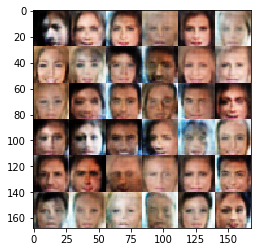

Epoch 1/2 Step 1610...... Discriminator Loss: 1.1342... Generator Loss: 0.7365
Epoch 1/2 Step 1620...... Discriminator Loss: 0.7929... Generator Loss: 1.2758
Epoch 1/2 Step 1630...... Discriminator Loss: 0.9384... Generator Loss: 1.8438
Epoch 1/2 Step 1640...... Discriminator Loss: 0.9063... Generator Loss: 1.9085
Epoch 1/2 Step 1650...... Discriminator Loss: 1.2129... Generator Loss: 0.7603
Epoch 1/2 Step 1660...... Discriminator Loss: 0.9420... Generator Loss: 1.5894
Epoch 1/2 Step 1670...... Discriminator Loss: 1.1276... Generator Loss: 0.9577
Epoch 1/2 Step 1680...... Discriminator Loss: 1.0140... Generator Loss: 0.9296
Epoch 1/2 Step 1690...... Discriminator Loss: 1.2125... Generator Loss: 0.8684
Epoch 1/2 Step 1700...... Discriminator Loss: 1.0157... Generator Loss: 0.9739


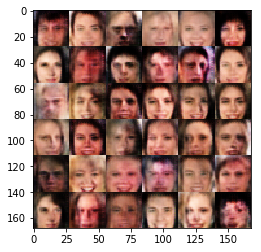

Epoch 1/2 Step 1710...... Discriminator Loss: 0.9706... Generator Loss: 1.4991
Epoch 1/2 Step 1720...... Discriminator Loss: 1.2791... Generator Loss: 3.3493
Epoch 1/2 Step 1730...... Discriminator Loss: 0.9650... Generator Loss: 1.2056
Epoch 1/2 Step 1740...... Discriminator Loss: 1.3744... Generator Loss: 0.5884
Epoch 1/2 Step 1750...... Discriminator Loss: 1.0592... Generator Loss: 0.9141
Epoch 1/2 Step 1760...... Discriminator Loss: 0.9150... Generator Loss: 1.5546
Epoch 1/2 Step 1770...... Discriminator Loss: 0.9081... Generator Loss: 1.2011
Epoch 1/2 Step 1780...... Discriminator Loss: 1.4279... Generator Loss: 2.5848
Epoch 1/2 Step 1790...... Discriminator Loss: 0.9645... Generator Loss: 1.6224
Epoch 1/2 Step 1800...... Discriminator Loss: 1.0582... Generator Loss: 0.9555


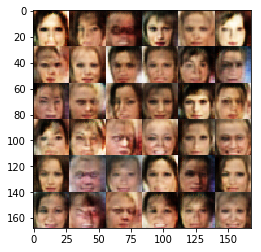

Epoch 1/2 Step 1810...... Discriminator Loss: 1.1369... Generator Loss: 2.0361
Epoch 1/2 Step 1820...... Discriminator Loss: 0.9137... Generator Loss: 1.6175
Epoch 1/2 Step 1830...... Discriminator Loss: 0.8811... Generator Loss: 1.3999
Epoch 1/2 Step 1840...... Discriminator Loss: 0.9579... Generator Loss: 1.5680
Epoch 1/2 Step 1850...... Discriminator Loss: 0.8411... Generator Loss: 1.4413
Epoch 1/2 Step 1860...... Discriminator Loss: 0.9382... Generator Loss: 1.1126
Epoch 1/2 Step 1870...... Discriminator Loss: 0.8634... Generator Loss: 1.7913
Epoch 1/2 Step 1880...... Discriminator Loss: 0.9379... Generator Loss: 1.1936
Epoch 1/2 Step 1890...... Discriminator Loss: 0.8984... Generator Loss: 2.0477
Epoch 1/2 Step 1900...... Discriminator Loss: 1.2918... Generator Loss: 0.6151


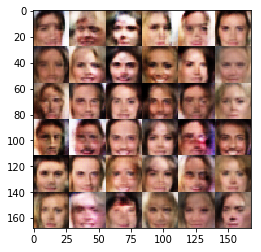

Epoch 1/2 Step 1910...... Discriminator Loss: 1.0836... Generator Loss: 1.5039
Epoch 1/2 Step 1920...... Discriminator Loss: 1.0222... Generator Loss: 1.3893
Epoch 1/2 Step 1930...... Discriminator Loss: 1.0760... Generator Loss: 0.9609
Epoch 1/2 Step 1940...... Discriminator Loss: 1.1284... Generator Loss: 0.7582
Epoch 1/2 Step 1950...... Discriminator Loss: 0.8906... Generator Loss: 1.2510
Epoch 1/2 Step 1960...... Discriminator Loss: 1.3185... Generator Loss: 2.1840
Epoch 1/2 Step 1970...... Discriminator Loss: 1.0535... Generator Loss: 1.6205
Epoch 1/2 Step 1980...... Discriminator Loss: 1.3785... Generator Loss: 0.6077
Epoch 1/2 Step 1990...... Discriminator Loss: 0.9498... Generator Loss: 1.2491
Epoch 1/2 Step 2000...... Discriminator Loss: 1.4321... Generator Loss: 0.5492


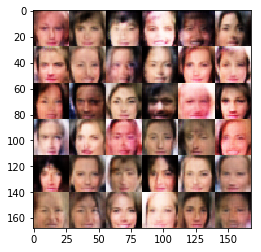

Epoch 1/2 Step 2010...... Discriminator Loss: 0.9883... Generator Loss: 1.1231
Epoch 1/2 Step 2020...... Discriminator Loss: 0.8421... Generator Loss: 1.4114
Epoch 1/2 Step 2030...... Discriminator Loss: 0.9517... Generator Loss: 0.9734
Epoch 1/2 Step 2040...... Discriminator Loss: 0.9775... Generator Loss: 1.0765
Epoch 1/2 Step 2050...... Discriminator Loss: 0.9829... Generator Loss: 2.2749
Epoch 1/2 Step 2060...... Discriminator Loss: 0.8172... Generator Loss: 1.2777
Epoch 1/2 Step 2070...... Discriminator Loss: 0.9793... Generator Loss: 1.8346
Epoch 1/2 Step 2080...... Discriminator Loss: 1.0134... Generator Loss: 0.9248
Epoch 1/2 Step 2090...... Discriminator Loss: 0.8439... Generator Loss: 1.7365
Epoch 1/2 Step 2100...... Discriminator Loss: 0.9343... Generator Loss: 1.0547


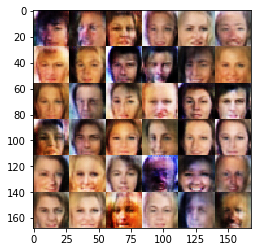

Epoch 1/2 Step 2110...... Discriminator Loss: 0.6263... Generator Loss: 1.7915
Epoch 1/2 Step 2120...... Discriminator Loss: 1.4288... Generator Loss: 2.3944
Epoch 1/2 Step 2130...... Discriminator Loss: 0.9043... Generator Loss: 1.1365
Epoch 1/2 Step 2140...... Discriminator Loss: 0.9711... Generator Loss: 1.2743
Epoch 1/2 Step 2150...... Discriminator Loss: 1.3013... Generator Loss: 0.6132
Epoch 1/2 Step 2160...... Discriminator Loss: 0.9874... Generator Loss: 1.0052
Epoch 1/2 Step 2170...... Discriminator Loss: 0.7179... Generator Loss: 1.8120
Epoch 1/2 Step 2180...... Discriminator Loss: 0.8750... Generator Loss: 1.2268
Epoch 1/2 Step 2190...... Discriminator Loss: 0.8429... Generator Loss: 1.5087
Epoch 1/2 Step 2200...... Discriminator Loss: 0.9816... Generator Loss: 0.9671


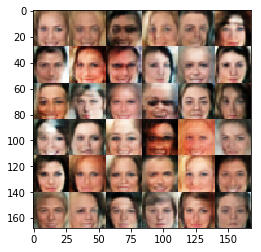

Epoch 1/2 Step 2210...... Discriminator Loss: 1.1148... Generator Loss: 1.6628
Epoch 1/2 Step 2220...... Discriminator Loss: 0.9390... Generator Loss: 2.1468
Epoch 1/2 Step 2230...... Discriminator Loss: 0.9737... Generator Loss: 2.1112
Epoch 1/2 Step 2240...... Discriminator Loss: 0.8962... Generator Loss: 2.0608
Epoch 1/2 Step 2250...... Discriminator Loss: 0.9364... Generator Loss: 1.3597
Epoch 1/2 Step 2260...... Discriminator Loss: 1.1958... Generator Loss: 2.4431
Epoch 1/2 Step 2270...... Discriminator Loss: 0.8465... Generator Loss: 1.6986
Epoch 1/2 Step 2280...... Discriminator Loss: 0.8676... Generator Loss: 1.4471
Epoch 1/2 Step 2290...... Discriminator Loss: 1.1238... Generator Loss: 1.9853
Epoch 1/2 Step 2300...... Discriminator Loss: 1.1390... Generator Loss: 0.9833


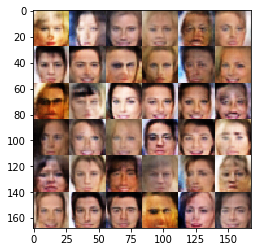

Epoch 1/2 Step 2310...... Discriminator Loss: 0.9796... Generator Loss: 2.3101
Epoch 1/2 Step 2320...... Discriminator Loss: 0.9400... Generator Loss: 2.0691
Epoch 1/2 Step 2330...... Discriminator Loss: 1.0339... Generator Loss: 1.1045
Epoch 1/2 Step 2340...... Discriminator Loss: 0.9028... Generator Loss: 1.1130
Epoch 1/2 Step 2350...... Discriminator Loss: 1.3548... Generator Loss: 2.6238
Epoch 1/2 Step 2360...... Discriminator Loss: 0.9114... Generator Loss: 1.2378
Epoch 1/2 Step 2370...... Discriminator Loss: 0.8731... Generator Loss: 1.4011
Epoch 1/2 Step 2380...... Discriminator Loss: 1.3038... Generator Loss: 0.6613
Epoch 1/2 Step 2390...... Discriminator Loss: 0.8585... Generator Loss: 1.0334
Epoch 1/2 Step 2400...... Discriminator Loss: 1.0436... Generator Loss: 1.5236


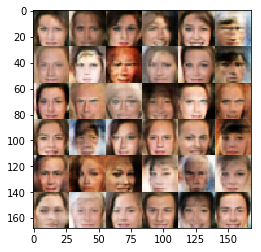

Epoch 1/2 Step 2410...... Discriminator Loss: 1.1280... Generator Loss: 0.8283
Epoch 1/2 Step 2420...... Discriminator Loss: 0.8457... Generator Loss: 2.1277
Epoch 1/2 Step 2430...... Discriminator Loss: 0.8139... Generator Loss: 1.5673
Epoch 1/2 Step 2440...... Discriminator Loss: 1.2307... Generator Loss: 0.5756
Epoch 1/2 Step 2450...... Discriminator Loss: 1.1944... Generator Loss: 0.7352
Epoch 1/2 Step 2460...... Discriminator Loss: 1.0379... Generator Loss: 0.9053
Epoch 1/2 Step 2470...... Discriminator Loss: 1.0191... Generator Loss: 0.8731
Epoch 1/2 Step 2480...... Discriminator Loss: 1.2905... Generator Loss: 0.5755
Epoch 1/2 Step 2490...... Discriminator Loss: 0.9634... Generator Loss: 2.3358
Epoch 1/2 Step 2500...... Discriminator Loss: 0.9399... Generator Loss: 1.1132


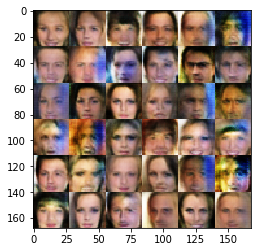

Epoch 1/2 Step 2510...... Discriminator Loss: 0.8754... Generator Loss: 1.4107
Epoch 1/2 Step 2520...... Discriminator Loss: 0.8781... Generator Loss: 1.4634
Epoch 1/2 Step 2530...... Discriminator Loss: 1.0001... Generator Loss: 2.2640
Epoch 1/2 Step 2540...... Discriminator Loss: 0.7954... Generator Loss: 1.6795
Epoch 1/2 Step 2550...... Discriminator Loss: 1.3765... Generator Loss: 0.5732
Epoch 1/2 Step 2560...... Discriminator Loss: 1.3617... Generator Loss: 2.0091
Epoch 1/2 Step 2570...... Discriminator Loss: 1.0912... Generator Loss: 0.8458
Epoch 1/2 Step 2580...... Discriminator Loss: 0.8690... Generator Loss: 1.3171
Epoch 1/2 Step 2590...... Discriminator Loss: 0.9650... Generator Loss: 1.4212
Epoch 1/2 Step 2600...... Discriminator Loss: 0.8671... Generator Loss: 1.1084


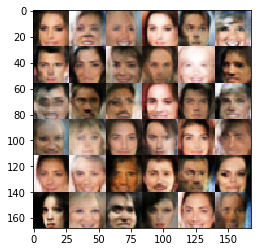

Epoch 1/2 Step 2610...... Discriminator Loss: 0.9193... Generator Loss: 1.3034
Epoch 1/2 Step 2620...... Discriminator Loss: 0.8161... Generator Loss: 1.5720
Epoch 1/2 Step 2630...... Discriminator Loss: 1.0674... Generator Loss: 0.8898
Epoch 1/2 Step 2640...... Discriminator Loss: 0.7135... Generator Loss: 1.9265
Epoch 1/2 Step 2650...... Discriminator Loss: 0.7158... Generator Loss: 1.7523
Epoch 1/2 Step 2660...... Discriminator Loss: 0.9263... Generator Loss: 1.6614
Epoch 1/2 Step 2670...... Discriminator Loss: 0.9293... Generator Loss: 3.2184
Epoch 1/2 Step 2680...... Discriminator Loss: 0.7490... Generator Loss: 1.3595
Epoch 1/2 Step 2690...... Discriminator Loss: 0.9643... Generator Loss: 1.1338
Epoch 1/2 Step 2700...... Discriminator Loss: 1.0882... Generator Loss: 0.8082


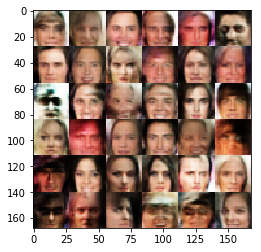

Epoch 1/2 Step 2710...... Discriminator Loss: 0.8864... Generator Loss: 1.1366
Epoch 1/2 Step 2720...... Discriminator Loss: 0.8373... Generator Loss: 1.1622
Epoch 1/2 Step 2730...... Discriminator Loss: 1.5550... Generator Loss: 2.0635
Epoch 1/2 Step 2740...... Discriminator Loss: 1.0779... Generator Loss: 0.7791
Epoch 1/2 Step 2750...... Discriminator Loss: 0.8558... Generator Loss: 1.3246
Epoch 1/2 Step 2760...... Discriminator Loss: 0.8080... Generator Loss: 1.5815
Epoch 1/2 Step 2770...... Discriminator Loss: 0.8367... Generator Loss: 1.4741
Epoch 1/2 Step 2780...... Discriminator Loss: 1.0122... Generator Loss: 0.8016
Epoch 1/2 Step 2790...... Discriminator Loss: 1.1459... Generator Loss: 0.8253
Epoch 1/2 Step 2800...... Discriminator Loss: 1.3806... Generator Loss: 0.5412


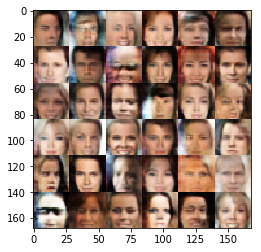

Epoch 1/2 Step 2810...... Discriminator Loss: 1.0489... Generator Loss: 0.8745
Epoch 1/2 Step 2820...... Discriminator Loss: 1.0439... Generator Loss: 1.2919
Epoch 1/2 Step 2830...... Discriminator Loss: 1.1914... Generator Loss: 0.7362
Epoch 1/2 Step 2840...... Discriminator Loss: 0.9192... Generator Loss: 1.5043
Epoch 1/2 Step 2850...... Discriminator Loss: 1.0839... Generator Loss: 2.0011
Epoch 1/2 Step 2860...... Discriminator Loss: 0.9891... Generator Loss: 0.8426
Epoch 1/2 Step 2870...... Discriminator Loss: 0.8709... Generator Loss: 2.0577
Epoch 1/2 Step 2880...... Discriminator Loss: 0.9846... Generator Loss: 1.4321
Epoch 1/2 Step 2890...... Discriminator Loss: 0.9580... Generator Loss: 0.8900
Epoch 1/2 Step 2900...... Discriminator Loss: 0.7781... Generator Loss: 1.3407


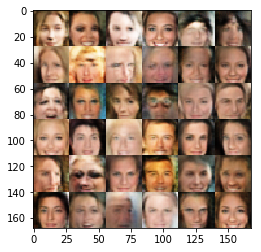

Epoch 1/2 Step 2910...... Discriminator Loss: 0.8314... Generator Loss: 1.1750
Epoch 1/2 Step 2920...... Discriminator Loss: 0.8265... Generator Loss: 1.4291
Epoch 1/2 Step 2930...... Discriminator Loss: 1.2143... Generator Loss: 0.7259
Epoch 1/2 Step 2940...... Discriminator Loss: 0.8190... Generator Loss: 1.4605
Epoch 1/2 Step 2950...... Discriminator Loss: 0.8058... Generator Loss: 1.4819
Epoch 1/2 Step 2960...... Discriminator Loss: 1.0356... Generator Loss: 0.9162
Epoch 1/2 Step 2970...... Discriminator Loss: 0.8759... Generator Loss: 1.1146
Epoch 1/2 Step 2980...... Discriminator Loss: 0.7263... Generator Loss: 1.8512
Epoch 1/2 Step 2990...... Discriminator Loss: 0.8288... Generator Loss: 1.7325
Epoch 1/2 Step 3000...... Discriminator Loss: 0.7555... Generator Loss: 1.7683


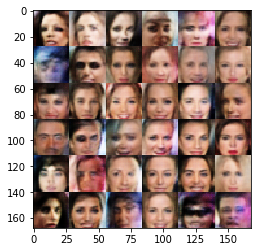

Epoch 1/2 Step 3010...... Discriminator Loss: 0.7579... Generator Loss: 1.3956
Epoch 1/2 Step 3020...... Discriminator Loss: 1.1112... Generator Loss: 0.8176
Epoch 1/2 Step 3030...... Discriminator Loss: 1.0401... Generator Loss: 0.8450
Epoch 1/2 Step 3040...... Discriminator Loss: 1.3306... Generator Loss: 2.2553
Epoch 1/2 Step 3050...... Discriminator Loss: 0.8050... Generator Loss: 1.2480
Epoch 1/2 Step 3060...... Discriminator Loss: 0.7109... Generator Loss: 1.7742
Epoch 1/2 Step 3070...... Discriminator Loss: 0.8225... Generator Loss: 1.9229
Epoch 1/2 Step 3080...... Discriminator Loss: 0.8592... Generator Loss: 1.6491
Epoch 1/2 Step 3090...... Discriminator Loss: 1.1645... Generator Loss: 0.7175
Epoch 1/2 Step 3100...... Discriminator Loss: 1.1556... Generator Loss: 0.6821


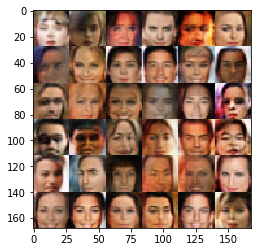

Epoch 1/2 Step 3110...... Discriminator Loss: 1.2964... Generator Loss: 2.6638
Epoch 1/2 Step 3120...... Discriminator Loss: 0.9746... Generator Loss: 1.1289
Epoch 1/2 Step 3130...... Discriminator Loss: 0.7894... Generator Loss: 1.8748
Epoch 1/2 Step 3140...... Discriminator Loss: 0.8235... Generator Loss: 1.4986
Epoch 1/2 Step 3150...... Discriminator Loss: 0.8548... Generator Loss: 1.5180
Epoch 1/2 Step 3160...... Discriminator Loss: 0.8411... Generator Loss: 1.2198
Epoch 2/2 Step 3170...... Discriminator Loss: 1.0067... Generator Loss: 1.6695
Epoch 2/2 Step 3180...... Discriminator Loss: 1.1408... Generator Loss: 0.8439
Epoch 2/2 Step 3190...... Discriminator Loss: 0.8991... Generator Loss: 1.6724
Epoch 2/2 Step 3200...... Discriminator Loss: 0.9754... Generator Loss: 1.2987


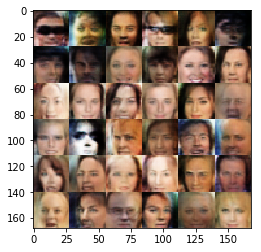

Epoch 2/2 Step 3210...... Discriminator Loss: 0.7989... Generator Loss: 1.7367
Epoch 2/2 Step 3220...... Discriminator Loss: 1.0730... Generator Loss: 0.8929
Epoch 2/2 Step 3230...... Discriminator Loss: 0.8487... Generator Loss: 1.4451
Epoch 2/2 Step 3240...... Discriminator Loss: 1.0329... Generator Loss: 1.3151
Epoch 2/2 Step 3250...... Discriminator Loss: 0.7795... Generator Loss: 1.4331
Epoch 2/2 Step 3260...... Discriminator Loss: 1.0655... Generator Loss: 2.5449
Epoch 2/2 Step 3270...... Discriminator Loss: 0.9215... Generator Loss: 1.1578
Epoch 2/2 Step 3280...... Discriminator Loss: 0.9319... Generator Loss: 1.1541
Epoch 2/2 Step 3290...... Discriminator Loss: 1.0248... Generator Loss: 1.3756
Epoch 2/2 Step 3300...... Discriminator Loss: 0.9270... Generator Loss: 2.2029


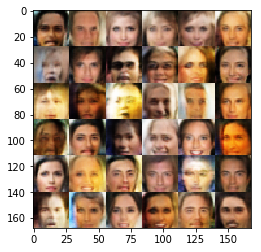

Epoch 2/2 Step 3310...... Discriminator Loss: 0.7193... Generator Loss: 1.9570
Epoch 2/2 Step 3320...... Discriminator Loss: 0.7458... Generator Loss: 1.6886
Epoch 2/2 Step 3330...... Discriminator Loss: 0.8891... Generator Loss: 2.0598
Epoch 2/2 Step 3340...... Discriminator Loss: 0.8546... Generator Loss: 1.4292
Epoch 2/2 Step 3350...... Discriminator Loss: 1.1343... Generator Loss: 1.6773
Epoch 2/2 Step 3360...... Discriminator Loss: 0.9765... Generator Loss: 1.7226
Epoch 2/2 Step 3370...... Discriminator Loss: 0.8555... Generator Loss: 2.1410
Epoch 2/2 Step 3380...... Discriminator Loss: 0.8375... Generator Loss: 1.5593
Epoch 2/2 Step 3390...... Discriminator Loss: 0.8120... Generator Loss: 1.3595
Epoch 2/2 Step 3400...... Discriminator Loss: 0.8062... Generator Loss: 1.6133


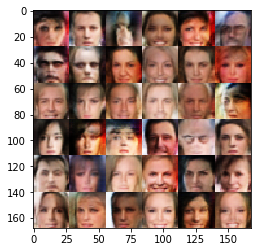

Epoch 2/2 Step 3410...... Discriminator Loss: 0.8395... Generator Loss: 1.5154
Epoch 2/2 Step 3420...... Discriminator Loss: 0.7792... Generator Loss: 1.5714
Epoch 2/2 Step 3430...... Discriminator Loss: 0.7220... Generator Loss: 1.7258
Epoch 2/2 Step 3440...... Discriminator Loss: 1.1140... Generator Loss: 0.7451
Epoch 2/2 Step 3450...... Discriminator Loss: 0.8629... Generator Loss: 1.1148
Epoch 2/2 Step 3460...... Discriminator Loss: 0.9722... Generator Loss: 1.2113
Epoch 2/2 Step 3470...... Discriminator Loss: 1.0273... Generator Loss: 2.0557
Epoch 2/2 Step 3480...... Discriminator Loss: 0.7548... Generator Loss: 1.6092
Epoch 2/2 Step 3490...... Discriminator Loss: 1.3625... Generator Loss: 0.5892
Epoch 2/2 Step 3500...... Discriminator Loss: 0.8379... Generator Loss: 1.5702


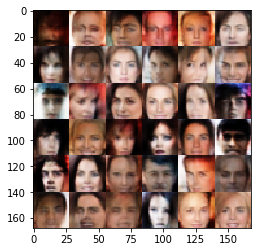

Epoch 2/2 Step 3510...... Discriminator Loss: 1.0597... Generator Loss: 0.9374
Epoch 2/2 Step 3520...... Discriminator Loss: 0.8469... Generator Loss: 1.8083
Epoch 2/2 Step 3530...... Discriminator Loss: 1.2306... Generator Loss: 1.6141
Epoch 2/2 Step 3540...... Discriminator Loss: 1.7654... Generator Loss: 2.5327
Epoch 2/2 Step 3550...... Discriminator Loss: 0.8125... Generator Loss: 1.6544
Epoch 2/2 Step 3560...... Discriminator Loss: 0.8844... Generator Loss: 1.5814
Epoch 2/2 Step 3570...... Discriminator Loss: 0.9528... Generator Loss: 1.3461
Epoch 2/2 Step 3580...... Discriminator Loss: 0.9802... Generator Loss: 1.0739
Epoch 2/2 Step 3590...... Discriminator Loss: 0.8125... Generator Loss: 1.8104
Epoch 2/2 Step 3600...... Discriminator Loss: 1.6073... Generator Loss: 0.3294


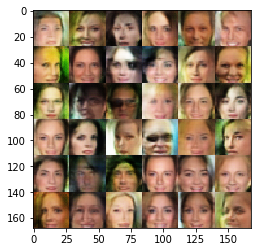

Epoch 2/2 Step 3610...... Discriminator Loss: 0.7858... Generator Loss: 1.5743
Epoch 2/2 Step 3620...... Discriminator Loss: 0.9067... Generator Loss: 0.9404
Epoch 2/2 Step 3630...... Discriminator Loss: 0.7451... Generator Loss: 1.4983
Epoch 2/2 Step 3640...... Discriminator Loss: 0.6975... Generator Loss: 1.9364
Epoch 2/2 Step 3650...... Discriminator Loss: 0.9367... Generator Loss: 1.7163
Epoch 2/2 Step 3660...... Discriminator Loss: 0.9262... Generator Loss: 1.1626
Epoch 2/2 Step 3670...... Discriminator Loss: 0.8296... Generator Loss: 1.3544
Epoch 2/2 Step 3680...... Discriminator Loss: 0.6327... Generator Loss: 1.8944
Epoch 2/2 Step 3690...... Discriminator Loss: 0.8736... Generator Loss: 1.6594
Epoch 2/2 Step 3700...... Discriminator Loss: 0.9659... Generator Loss: 1.3237


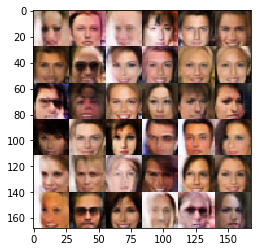

Epoch 2/2 Step 3710...... Discriminator Loss: 0.7583... Generator Loss: 1.3672
Epoch 2/2 Step 3720...... Discriminator Loss: 0.8128... Generator Loss: 1.2082
Epoch 2/2 Step 3730...... Discriminator Loss: 0.9190... Generator Loss: 1.5848
Epoch 2/2 Step 3740...... Discriminator Loss: 0.8220... Generator Loss: 2.0097
Epoch 2/2 Step 3750...... Discriminator Loss: 1.0069... Generator Loss: 0.8700
Epoch 2/2 Step 3760...... Discriminator Loss: 0.9748... Generator Loss: 0.9059
Epoch 2/2 Step 3770...... Discriminator Loss: 1.0207... Generator Loss: 1.2499
Epoch 2/2 Step 3780...... Discriminator Loss: 0.8684... Generator Loss: 1.2532
Epoch 2/2 Step 3790...... Discriminator Loss: 0.9581... Generator Loss: 1.1127
Epoch 2/2 Step 3800...... Discriminator Loss: 0.9902... Generator Loss: 1.0260


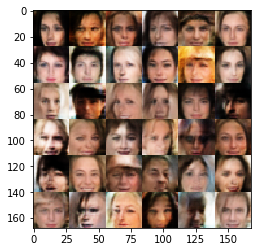

Epoch 2/2 Step 3810...... Discriminator Loss: 0.7880... Generator Loss: 1.5066
Epoch 2/2 Step 3820...... Discriminator Loss: 1.0016... Generator Loss: 1.1186
Epoch 2/2 Step 3830...... Discriminator Loss: 1.0915... Generator Loss: 0.7886
Epoch 2/2 Step 3840...... Discriminator Loss: 0.9332... Generator Loss: 0.9879
Epoch 2/2 Step 3850...... Discriminator Loss: 0.8208... Generator Loss: 1.6044
Epoch 2/2 Step 3860...... Discriminator Loss: 0.8138... Generator Loss: 1.3470
Epoch 2/2 Step 3870...... Discriminator Loss: 0.9829... Generator Loss: 0.9222
Epoch 2/2 Step 3880...... Discriminator Loss: 0.7561... Generator Loss: 1.3449
Epoch 2/2 Step 3890...... Discriminator Loss: 0.7658... Generator Loss: 1.5355
Epoch 2/2 Step 3900...... Discriminator Loss: 0.8423... Generator Loss: 1.3256


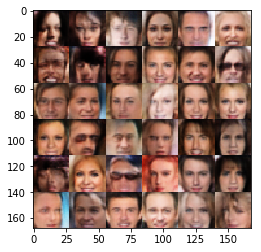

Epoch 2/2 Step 3910...... Discriminator Loss: 1.0756... Generator Loss: 2.4069
Epoch 2/2 Step 3920...... Discriminator Loss: 1.1384... Generator Loss: 0.7453
Epoch 2/2 Step 3930...... Discriminator Loss: 1.1833... Generator Loss: 2.2772
Epoch 2/2 Step 3940...... Discriminator Loss: 0.7458... Generator Loss: 1.5996
Epoch 2/2 Step 3950...... Discriminator Loss: 1.0861... Generator Loss: 1.2544
Epoch 2/2 Step 3960...... Discriminator Loss: 0.8455... Generator Loss: 1.6422
Epoch 2/2 Step 3970...... Discriminator Loss: 0.7693... Generator Loss: 1.4631
Epoch 2/2 Step 3980...... Discriminator Loss: 0.7673... Generator Loss: 1.2901
Epoch 2/2 Step 3990...... Discriminator Loss: 1.5652... Generator Loss: 1.9288
Epoch 2/2 Step 4000...... Discriminator Loss: 0.8545... Generator Loss: 1.7015


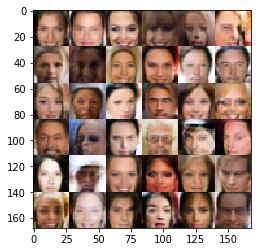

Epoch 2/2 Step 4010...... Discriminator Loss: 0.8824... Generator Loss: 1.0296
Epoch 2/2 Step 4020...... Discriminator Loss: 1.1005... Generator Loss: 2.6448
Epoch 2/2 Step 4030...... Discriminator Loss: 0.9553... Generator Loss: 1.0095
Epoch 2/2 Step 4040...... Discriminator Loss: 1.0045... Generator Loss: 1.1898
Epoch 2/2 Step 4050...... Discriminator Loss: 1.0856... Generator Loss: 2.1814
Epoch 2/2 Step 4060...... Discriminator Loss: 0.8670... Generator Loss: 1.2831
Epoch 2/2 Step 4070...... Discriminator Loss: 0.8900... Generator Loss: 1.0636
Epoch 2/2 Step 4080...... Discriminator Loss: 0.8175... Generator Loss: 1.4416
Epoch 2/2 Step 4090...... Discriminator Loss: 1.0073... Generator Loss: 1.5853
Epoch 2/2 Step 4100...... Discriminator Loss: 0.7565... Generator Loss: 1.2985


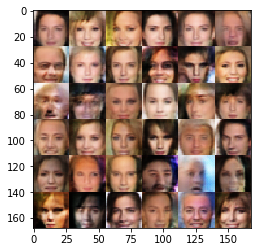

Epoch 2/2 Step 4110...... Discriminator Loss: 0.7013... Generator Loss: 1.5959
Epoch 2/2 Step 4120...... Discriminator Loss: 1.1829... Generator Loss: 0.6812
Epoch 2/2 Step 4130...... Discriminator Loss: 1.3355... Generator Loss: 1.7798
Epoch 2/2 Step 4140...... Discriminator Loss: 1.3054... Generator Loss: 0.5597
Epoch 2/2 Step 4150...... Discriminator Loss: 0.9536... Generator Loss: 1.2632
Epoch 2/2 Step 4160...... Discriminator Loss: 0.8895... Generator Loss: 2.3099
Epoch 2/2 Step 4170...... Discriminator Loss: 1.0578... Generator Loss: 0.7540
Epoch 2/2 Step 4180...... Discriminator Loss: 0.9497... Generator Loss: 1.2707
Epoch 2/2 Step 4190...... Discriminator Loss: 0.8526... Generator Loss: 1.1465
Epoch 2/2 Step 4200...... Discriminator Loss: 1.0044... Generator Loss: 0.9709


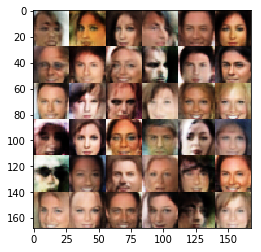

Epoch 2/2 Step 4210...... Discriminator Loss: 1.0479... Generator Loss: 0.7814
Epoch 2/2 Step 4220...... Discriminator Loss: 0.8520... Generator Loss: 2.1006
Epoch 2/2 Step 4230...... Discriminator Loss: 0.9606... Generator Loss: 1.0320
Epoch 2/2 Step 4240...... Discriminator Loss: 0.8726... Generator Loss: 1.0126
Epoch 2/2 Step 4250...... Discriminator Loss: 0.6247... Generator Loss: 1.5658
Epoch 2/2 Step 4260...... Discriminator Loss: 0.7358... Generator Loss: 1.3419
Epoch 2/2 Step 4270...... Discriminator Loss: 1.0403... Generator Loss: 2.1952
Epoch 2/2 Step 4280...... Discriminator Loss: 0.8197... Generator Loss: 1.4339
Epoch 2/2 Step 4290...... Discriminator Loss: 0.7653... Generator Loss: 1.1210
Epoch 2/2 Step 4300...... Discriminator Loss: 0.6792... Generator Loss: 1.7829


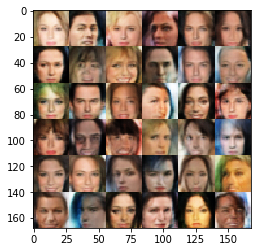

Epoch 2/2 Step 4310...... Discriminator Loss: 0.7245... Generator Loss: 1.3607
Epoch 2/2 Step 4320...... Discriminator Loss: 1.0622... Generator Loss: 0.8211
Epoch 2/2 Step 4330...... Discriminator Loss: 0.8595... Generator Loss: 1.4310
Epoch 2/2 Step 4340...... Discriminator Loss: 0.7246... Generator Loss: 1.3512
Epoch 2/2 Step 4350...... Discriminator Loss: 1.5355... Generator Loss: 0.4712
Epoch 2/2 Step 4360...... Discriminator Loss: 0.9193... Generator Loss: 1.8167
Epoch 2/2 Step 4370...... Discriminator Loss: 0.9385... Generator Loss: 1.3834
Epoch 2/2 Step 4380...... Discriminator Loss: 1.6090... Generator Loss: 2.8409
Epoch 2/2 Step 4390...... Discriminator Loss: 0.6976... Generator Loss: 2.4022
Epoch 2/2 Step 4400...... Discriminator Loss: 0.7885... Generator Loss: 1.1255


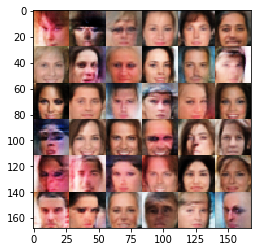

Epoch 2/2 Step 4410...... Discriminator Loss: 0.7825... Generator Loss: 1.2073
Epoch 2/2 Step 4420...... Discriminator Loss: 1.0012... Generator Loss: 1.3279
Epoch 2/2 Step 4430...... Discriminator Loss: 0.9488... Generator Loss: 0.9710
Epoch 2/2 Step 4440...... Discriminator Loss: 0.8873... Generator Loss: 1.0864
Epoch 2/2 Step 4450...... Discriminator Loss: 0.6565... Generator Loss: 1.6050
Epoch 2/2 Step 4460...... Discriminator Loss: 0.9167... Generator Loss: 1.0878
Epoch 2/2 Step 4470...... Discriminator Loss: 0.8579... Generator Loss: 1.1806
Epoch 2/2 Step 4480...... Discriminator Loss: 0.8759... Generator Loss: 1.0298
Epoch 2/2 Step 4490...... Discriminator Loss: 0.9106... Generator Loss: 0.8921
Epoch 2/2 Step 4500...... Discriminator Loss: 0.8065... Generator Loss: 1.1521


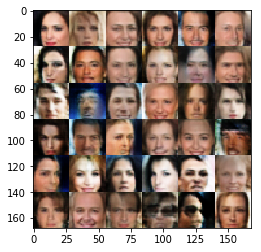

Epoch 2/2 Step 4510...... Discriminator Loss: 0.6943... Generator Loss: 1.6755
Epoch 2/2 Step 4520...... Discriminator Loss: 1.0181... Generator Loss: 0.7981
Epoch 2/2 Step 4530...... Discriminator Loss: 0.7064... Generator Loss: 2.4534
Epoch 2/2 Step 4540...... Discriminator Loss: 0.7808... Generator Loss: 1.2688
Epoch 2/2 Step 4550...... Discriminator Loss: 0.8984... Generator Loss: 2.3285
Epoch 2/2 Step 4560...... Discriminator Loss: 0.9759... Generator Loss: 1.0250
Epoch 2/2 Step 4570...... Discriminator Loss: 0.9591... Generator Loss: 1.0612
Epoch 2/2 Step 4580...... Discriminator Loss: 1.0382... Generator Loss: 0.9039
Epoch 2/2 Step 4590...... Discriminator Loss: 0.6831... Generator Loss: 1.3810
Epoch 2/2 Step 4600...... Discriminator Loss: 0.8458... Generator Loss: 1.0491


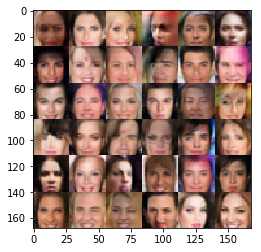

Epoch 2/2 Step 4610...... Discriminator Loss: 1.5398... Generator Loss: 0.5049
Epoch 2/2 Step 4620...... Discriminator Loss: 0.8091... Generator Loss: 1.1961
Epoch 2/2 Step 4630...... Discriminator Loss: 0.9867... Generator Loss: 2.8918
Epoch 2/2 Step 4640...... Discriminator Loss: 1.0107... Generator Loss: 1.9571
Epoch 2/2 Step 4650...... Discriminator Loss: 0.7410... Generator Loss: 1.5693
Epoch 2/2 Step 4660...... Discriminator Loss: 0.9786... Generator Loss: 1.5238
Epoch 2/2 Step 4670...... Discriminator Loss: 1.1855... Generator Loss: 0.6842
Epoch 2/2 Step 4680...... Discriminator Loss: 0.8510... Generator Loss: 2.3254
Epoch 2/2 Step 4690...... Discriminator Loss: 0.7061... Generator Loss: 1.6024
Epoch 2/2 Step 4700...... Discriminator Loss: 1.1680... Generator Loss: 0.7214


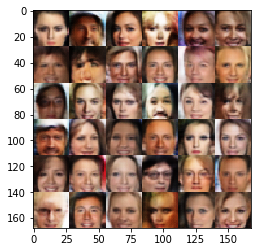

Epoch 2/2 Step 4710...... Discriminator Loss: 0.6556... Generator Loss: 2.1335
Epoch 2/2 Step 4720...... Discriminator Loss: 0.5555... Generator Loss: 2.2294
Epoch 2/2 Step 4730...... Discriminator Loss: 0.8500... Generator Loss: 1.2295
Epoch 2/2 Step 4740...... Discriminator Loss: 0.9208... Generator Loss: 1.7314
Epoch 2/2 Step 4750...... Discriminator Loss: 0.8653... Generator Loss: 1.0624
Epoch 2/2 Step 4760...... Discriminator Loss: 0.6395... Generator Loss: 1.5399
Epoch 2/2 Step 4770...... Discriminator Loss: 0.7713... Generator Loss: 1.1071
Epoch 2/2 Step 4780...... Discriminator Loss: 1.0257... Generator Loss: 2.1610
Epoch 2/2 Step 4790...... Discriminator Loss: 0.7451... Generator Loss: 1.4771
Epoch 2/2 Step 4800...... Discriminator Loss: 0.8071... Generator Loss: 2.0324


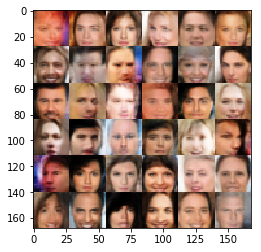

Epoch 2/2 Step 4810...... Discriminator Loss: 1.3129... Generator Loss: 0.5387
Epoch 2/2 Step 4820...... Discriminator Loss: 0.6805... Generator Loss: 2.2507
Epoch 2/2 Step 4830...... Discriminator Loss: 0.8317... Generator Loss: 2.7801
Epoch 2/2 Step 4840...... Discriminator Loss: 0.9877... Generator Loss: 1.0073
Epoch 2/2 Step 4850...... Discriminator Loss: 0.8128... Generator Loss: 1.1668
Epoch 2/2 Step 4860...... Discriminator Loss: 0.7274... Generator Loss: 1.7663
Epoch 2/2 Step 4870...... Discriminator Loss: 1.1533... Generator Loss: 2.0489
Epoch 2/2 Step 4880...... Discriminator Loss: 1.0614... Generator Loss: 1.7747
Epoch 2/2 Step 4890...... Discriminator Loss: 0.7584... Generator Loss: 1.7069
Epoch 2/2 Step 4900...... Discriminator Loss: 0.8191... Generator Loss: 1.2569


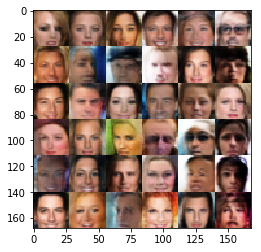

Epoch 2/2 Step 4910...... Discriminator Loss: 0.6931... Generator Loss: 1.6350
Epoch 2/2 Step 4920...... Discriminator Loss: 0.9134... Generator Loss: 1.2815
Epoch 2/2 Step 4930...... Discriminator Loss: 0.9457... Generator Loss: 0.9223
Epoch 2/2 Step 4940...... Discriminator Loss: 1.1625... Generator Loss: 0.6660
Epoch 2/2 Step 4950...... Discriminator Loss: 0.8804... Generator Loss: 1.1377
Epoch 2/2 Step 4960...... Discriminator Loss: 0.8454... Generator Loss: 1.2067
Epoch 2/2 Step 4970...... Discriminator Loss: 0.8470... Generator Loss: 1.1262
Epoch 2/2 Step 4980...... Discriminator Loss: 0.7805... Generator Loss: 1.2747
Epoch 2/2 Step 4990...... Discriminator Loss: 0.8985... Generator Loss: 2.0162
Epoch 2/2 Step 5000...... Discriminator Loss: 0.7956... Generator Loss: 1.7138


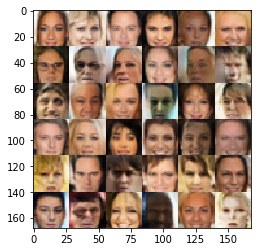

Epoch 2/2 Step 5010...... Discriminator Loss: 0.8201... Generator Loss: 2.2770
Epoch 2/2 Step 5020...... Discriminator Loss: 0.6904... Generator Loss: 1.3901
Epoch 2/2 Step 5030...... Discriminator Loss: 0.9122... Generator Loss: 1.0595
Epoch 2/2 Step 5040...... Discriminator Loss: 0.9035... Generator Loss: 1.5127
Epoch 2/2 Step 5050...... Discriminator Loss: 0.9955... Generator Loss: 1.7538
Epoch 2/2 Step 5060...... Discriminator Loss: 1.4855... Generator Loss: 0.5435
Epoch 2/2 Step 5070...... Discriminator Loss: 0.9599... Generator Loss: 0.9552
Epoch 2/2 Step 5080...... Discriminator Loss: 1.0216... Generator Loss: 0.8893
Epoch 2/2 Step 5090...... Discriminator Loss: 0.9195... Generator Loss: 1.8743
Epoch 2/2 Step 5100...... Discriminator Loss: 0.7525... Generator Loss: 1.3665


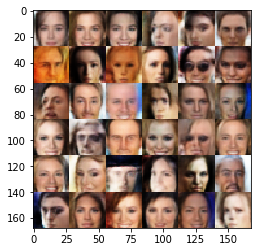

Epoch 2/2 Step 5110...... Discriminator Loss: 0.9903... Generator Loss: 1.0406
Epoch 2/2 Step 5120...... Discriminator Loss: 0.6852... Generator Loss: 1.9046
Epoch 2/2 Step 5130...... Discriminator Loss: 0.7394... Generator Loss: 1.5761
Epoch 2/2 Step 5140...... Discriminator Loss: 0.7609... Generator Loss: 1.4026
Epoch 2/2 Step 5150...... Discriminator Loss: 1.0079... Generator Loss: 0.9588
Epoch 2/2 Step 5160...... Discriminator Loss: 2.5335... Generator Loss: 0.1700
Epoch 2/2 Step 5170...... Discriminator Loss: 1.1095... Generator Loss: 1.0663
Epoch 2/2 Step 5180...... Discriminator Loss: 0.7367... Generator Loss: 1.4539
Epoch 2/2 Step 5190...... Discriminator Loss: 0.9409... Generator Loss: 1.2692
Epoch 2/2 Step 5200...... Discriminator Loss: 0.8310... Generator Loss: 1.1144


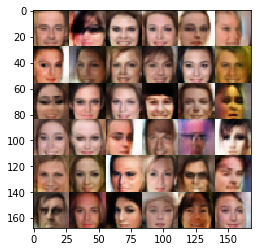

Epoch 2/2 Step 5210...... Discriminator Loss: 0.8421... Generator Loss: 0.9341
Epoch 2/2 Step 5220...... Discriminator Loss: 0.7252... Generator Loss: 1.3903
Epoch 2/2 Step 5230...... Discriminator Loss: 1.0514... Generator Loss: 0.9128
Epoch 2/2 Step 5240...... Discriminator Loss: 1.0768... Generator Loss: 3.0422
Epoch 2/2 Step 5250...... Discriminator Loss: 0.6302... Generator Loss: 1.6280
Epoch 2/2 Step 5260...... Discriminator Loss: 0.8992... Generator Loss: 1.6027
Epoch 2/2 Step 5270...... Discriminator Loss: 0.9743... Generator Loss: 0.9497
Epoch 2/2 Step 5280...... Discriminator Loss: 0.7013... Generator Loss: 1.8481
Epoch 2/2 Step 5290...... Discriminator Loss: 1.3688... Generator Loss: 2.5507
Epoch 2/2 Step 5300...... Discriminator Loss: 0.8434... Generator Loss: 1.8585


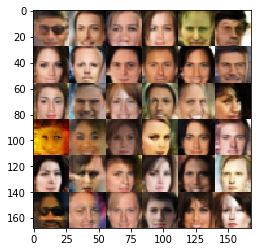

Epoch 2/2 Step 5310...... Discriminator Loss: 0.8356... Generator Loss: 1.1969
Epoch 2/2 Step 5320...... Discriminator Loss: 1.1503... Generator Loss: 3.0656
Epoch 2/2 Step 5330...... Discriminator Loss: 0.9949... Generator Loss: 0.9319
Epoch 2/2 Step 5340...... Discriminator Loss: 0.7578... Generator Loss: 1.7897
Epoch 2/2 Step 5350...... Discriminator Loss: 0.7159... Generator Loss: 1.6470
Epoch 2/2 Step 5360...... Discriminator Loss: 0.8255... Generator Loss: 1.5893
Epoch 2/2 Step 5370...... Discriminator Loss: 0.7957... Generator Loss: 1.2642
Epoch 2/2 Step 5380...... Discriminator Loss: 0.7009... Generator Loss: 1.6418
Epoch 2/2 Step 5390...... Discriminator Loss: 0.5973... Generator Loss: 2.8090
Epoch 2/2 Step 5400...... Discriminator Loss: 1.0010... Generator Loss: 1.0559


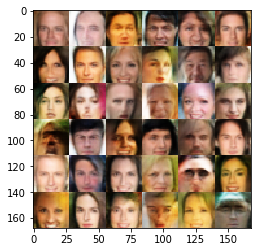

Epoch 2/2 Step 5410...... Discriminator Loss: 2.0840... Generator Loss: 3.9546
Epoch 2/2 Step 5420...... Discriminator Loss: 1.8756... Generator Loss: 3.6472
Epoch 2/2 Step 5430...... Discriminator Loss: 0.9391... Generator Loss: 1.0715
Epoch 2/2 Step 5440...... Discriminator Loss: 0.8539... Generator Loss: 1.1795
Epoch 2/2 Step 5450...... Discriminator Loss: 0.8142... Generator Loss: 1.3684
Epoch 2/2 Step 5460...... Discriminator Loss: 0.5165... Generator Loss: 2.2107
Epoch 2/2 Step 5470...... Discriminator Loss: 0.7567... Generator Loss: 1.7353
Epoch 2/2 Step 5480...... Discriminator Loss: 0.7151... Generator Loss: 1.5805
Epoch 2/2 Step 5490...... Discriminator Loss: 0.8558... Generator Loss: 1.1643
Epoch 2/2 Step 5500...... Discriminator Loss: 0.8328... Generator Loss: 1.0711


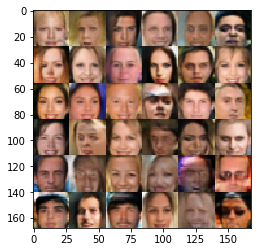

Epoch 2/2 Step 5510...... Discriminator Loss: 0.6144... Generator Loss: 2.3246
Epoch 2/2 Step 5520...... Discriminator Loss: 1.0864... Generator Loss: 0.7610
Epoch 2/2 Step 5530...... Discriminator Loss: 0.7824... Generator Loss: 1.2457
Epoch 2/2 Step 5540...... Discriminator Loss: 0.6318... Generator Loss: 1.6235
Epoch 2/2 Step 5550...... Discriminator Loss: 0.8645... Generator Loss: 0.9689
Epoch 2/2 Step 5560...... Discriminator Loss: 0.6029... Generator Loss: 1.8626
Epoch 2/2 Step 5570...... Discriminator Loss: 1.1174... Generator Loss: 2.1174
Epoch 2/2 Step 5580...... Discriminator Loss: 0.8931... Generator Loss: 1.8136
Epoch 2/2 Step 5590...... Discriminator Loss: 1.0235... Generator Loss: 0.8919
Epoch 2/2 Step 5600...... Discriminator Loss: 0.8703... Generator Loss: 1.2396


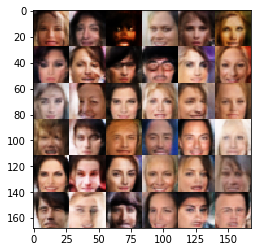

Epoch 2/2 Step 5610...... Discriminator Loss: 0.6276... Generator Loss: 2.5625
Epoch 2/2 Step 5620...... Discriminator Loss: 1.1392... Generator Loss: 0.7260
Epoch 2/2 Step 5630...... Discriminator Loss: 0.6650... Generator Loss: 2.4051
Epoch 2/2 Step 5640...... Discriminator Loss: 0.6976... Generator Loss: 1.4945
Epoch 2/2 Step 5650...... Discriminator Loss: 1.1633... Generator Loss: 2.6316
Epoch 2/2 Step 5660...... Discriminator Loss: 0.8337... Generator Loss: 1.1417
Epoch 2/2 Step 5670...... Discriminator Loss: 0.7419... Generator Loss: 1.4970
Epoch 2/2 Step 5680...... Discriminator Loss: 0.6668... Generator Loss: 1.6794
Epoch 2/2 Step 5690...... Discriminator Loss: 0.9210... Generator Loss: 2.1399
Epoch 2/2 Step 5700...... Discriminator Loss: 0.7799... Generator Loss: 1.2974


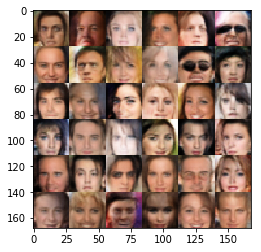

Epoch 2/2 Step 5710...... Discriminator Loss: 0.7834... Generator Loss: 1.8349
Epoch 2/2 Step 5720...... Discriminator Loss: 0.9837... Generator Loss: 0.9786
Epoch 2/2 Step 5730...... Discriminator Loss: 0.7489... Generator Loss: 1.4664
Epoch 2/2 Step 5740...... Discriminator Loss: 1.5101... Generator Loss: 0.4310
Epoch 2/2 Step 5750...... Discriminator Loss: 0.9296... Generator Loss: 2.5795
Epoch 2/2 Step 5760...... Discriminator Loss: 1.0502... Generator Loss: 2.8409
Epoch 2/2 Step 5770...... Discriminator Loss: 1.0755... Generator Loss: 2.2950
Epoch 2/2 Step 5780...... Discriminator Loss: 0.8016... Generator Loss: 1.6485
Epoch 2/2 Step 5790...... Discriminator Loss: 0.9426... Generator Loss: 2.6252
Epoch 2/2 Step 5800...... Discriminator Loss: 0.6683... Generator Loss: 1.5703


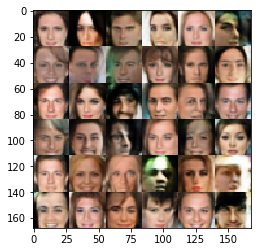

Epoch 2/2 Step 5810...... Discriminator Loss: 0.8041... Generator Loss: 1.1065
Epoch 2/2 Step 5820...... Discriminator Loss: 0.7089... Generator Loss: 1.7103
Epoch 2/2 Step 5830...... Discriminator Loss: 1.0424... Generator Loss: 2.1423
Epoch 2/2 Step 5840...... Discriminator Loss: 0.9507... Generator Loss: 2.1012
Epoch 2/2 Step 5850...... Discriminator Loss: 0.8574... Generator Loss: 2.5252
Epoch 2/2 Step 5860...... Discriminator Loss: 0.6759... Generator Loss: 1.4652
Epoch 2/2 Step 5870...... Discriminator Loss: 0.7193... Generator Loss: 1.4689
Epoch 2/2 Step 5880...... Discriminator Loss: 0.9979... Generator Loss: 0.9405
Epoch 2/2 Step 5890...... Discriminator Loss: 0.6377... Generator Loss: 2.0171
Epoch 2/2 Step 5900...... Discriminator Loss: 0.8940... Generator Loss: 1.0211


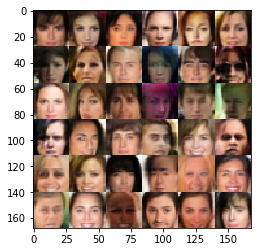

Epoch 2/2 Step 5910...... Discriminator Loss: 0.9045... Generator Loss: 1.1117
Epoch 2/2 Step 5920...... Discriminator Loss: 0.7402... Generator Loss: 1.4913
Epoch 2/2 Step 5930...... Discriminator Loss: 0.6892... Generator Loss: 1.3000
Epoch 2/2 Step 5940...... Discriminator Loss: 0.6580... Generator Loss: 1.8933
Epoch 2/2 Step 5950...... Discriminator Loss: 0.7575... Generator Loss: 1.9657
Epoch 2/2 Step 5960...... Discriminator Loss: 0.6354... Generator Loss: 1.8125
Epoch 2/2 Step 5970...... Discriminator Loss: 0.7350... Generator Loss: 2.2941
Epoch 2/2 Step 5980...... Discriminator Loss: 0.6951... Generator Loss: 1.4627
Epoch 2/2 Step 5990...... Discriminator Loss: 0.9655... Generator Loss: 1.6275
Epoch 2/2 Step 6000...... Discriminator Loss: 0.8405... Generator Loss: 1.1386


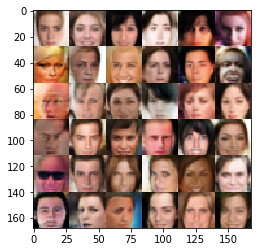

Epoch 2/2 Step 6010...... Discriminator Loss: 0.6571... Generator Loss: 2.6240
Epoch 2/2 Step 6020...... Discriminator Loss: 0.7422... Generator Loss: 2.2915
Epoch 2/2 Step 6030...... Discriminator Loss: 0.8655... Generator Loss: 1.0719
Epoch 2/2 Step 6040...... Discriminator Loss: 0.8651... Generator Loss: 1.1193
Epoch 2/2 Step 6050...... Discriminator Loss: 0.7775... Generator Loss: 1.7053
Epoch 2/2 Step 6060...... Discriminator Loss: 0.8858... Generator Loss: 2.5010
Epoch 2/2 Step 6070...... Discriminator Loss: 0.7525... Generator Loss: 2.9383
Epoch 2/2 Step 6080...... Discriminator Loss: 0.7615... Generator Loss: 1.5270
Epoch 2/2 Step 6090...... Discriminator Loss: 0.5645... Generator Loss: 1.9749
Epoch 2/2 Step 6100...... Discriminator Loss: 0.9269... Generator Loss: 1.3405


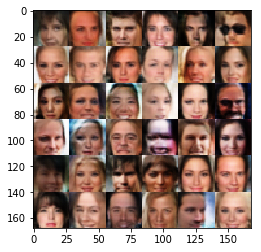

Epoch 2/2 Step 6110...... Discriminator Loss: 1.1929... Generator Loss: 0.6893
Epoch 2/2 Step 6120...... Discriminator Loss: 1.0025... Generator Loss: 1.1472
Epoch 2/2 Step 6130...... Discriminator Loss: 0.8402... Generator Loss: 1.3703
Epoch 2/2 Step 6140...... Discriminator Loss: 0.6574... Generator Loss: 1.8629
Epoch 2/2 Step 6150...... Discriminator Loss: 0.7212... Generator Loss: 1.5189
Epoch 2/2 Step 6160...... Discriminator Loss: 0.6946... Generator Loss: 2.3419
Epoch 2/2 Step 6170...... Discriminator Loss: 0.7610... Generator Loss: 1.4760
Epoch 2/2 Step 6180...... Discriminator Loss: 1.3046... Generator Loss: 2.6152
Epoch 2/2 Step 6190...... Discriminator Loss: 0.8598... Generator Loss: 1.1478
Epoch 2/2 Step 6200...... Discriminator Loss: 0.7169... Generator Loss: 1.7651


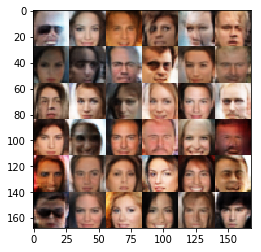

Epoch 2/2 Step 6210...... Discriminator Loss: 0.7498... Generator Loss: 1.3412
Epoch 2/2 Step 6220...... Discriminator Loss: 0.6709... Generator Loss: 2.1086
Epoch 2/2 Step 6230...... Discriminator Loss: 0.6390... Generator Loss: 2.0888
Epoch 2/2 Step 6240...... Discriminator Loss: 0.8669... Generator Loss: 1.0547
Epoch 2/2 Step 6250...... Discriminator Loss: 0.8339... Generator Loss: 1.1325
Epoch 2/2 Step 6260...... Discriminator Loss: 0.6514... Generator Loss: 2.0265
Epoch 2/2 Step 6270...... Discriminator Loss: 0.6010... Generator Loss: 2.1240
Epoch 2/2 Step 6280...... Discriminator Loss: 0.5817... Generator Loss: 1.9382
Epoch 2/2 Step 6290...... Discriminator Loss: 0.9432... Generator Loss: 1.9600
Epoch 2/2 Step 6300...... Discriminator Loss: 0.6269... Generator Loss: 2.0333


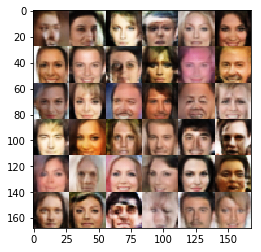

Epoch 2/2 Step 6310...... Discriminator Loss: 0.6836... Generator Loss: 1.3504
Epoch 2/2 Step 6320...... Discriminator Loss: 0.7214... Generator Loss: 1.8051
Epoch 2/2 Step 6330...... Discriminator Loss: 1.4020... Generator Loss: 0.5503


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.